#Feature extraction from sequences

In [ ]:
import h5py
import torch
import numpy as np
import pandas as pd

# === Constants ===
SAMPLE_RATE = 100.0  # Hz
DURATION = 90.0
EXPECTED_SAMPLES = int(SAMPLE_RATE * DURATION)

# === ROCOF Calculation ===
def compute_max_rocof(signal: torch.Tensor, sample_rate: float = SAMPLE_RATE) -> float:
    N = len(signal)
    fft_signal = torch.fft.fft(signal)
    analytic_fft = torch.cat([
        fft_signal[0:1],
        2 * fft_signal[1:N//2],
        fft_signal[N//2:N//2+1],
        torch.zeros(N - N//2 - 1, device=signal.device)
    ])
    analytic_signal = torch.fft.ifft(analytic_fft)
    phase = torch.angle(analytic_signal)
    instantaneous_freq = torch.diff(phase) * (sample_rate / (2 * torch.pi))
    rocof = torch.diff(instantaneous_freq) * sample_rate
    return torch.max(torch.abs(rocof)).item()

# === Nadir Time Calculation ===
def find_nadir_time(signal: torch.Tensor, sample_rate: float = SAMPLE_RATE) -> float:
    nadir_idx = torch.argmin(signal).item()
    return nadir_idx / sample_rate

# === RMS Ratio ===
def compute_rms_ratio(signal, early_pct=0.3, late_pct=0.1):
    T = signal.shape[0]
    early_len = int(T * early_pct)
    late_len = int(T * late_pct)
    # Ensure indices are within bounds
    if early_len == 0: early_len = 1
    if late_len == 0: late_len = 1
    early_rms = torch.sqrt(torch.mean(signal[:early_len] ** 2)).item()
    late_rms = torch.sqrt(torch.mean(signal[-late_len:] ** 2)).item()
    return late_rms / (early_rms + 1e-8)

# === Feature Extraction ===
def extract_features(signal, sample_rate=SAMPLE_RATE):
    return {
        'mean': signal.mean().item(),
        'std': signal.std().item(),
        'max': signal.max().item(),
        'min': signal.min().item(),
        'ptp': (signal.max() - signal.min()).item(),
        'rms': torch.sqrt(torch.mean(signal**2)).item(),
        'max_rocof': compute_max_rocof(signal, sample_rate),
        'nadir_time': find_nadir_time(signal, sample_rate)
    }

# === Load the Dataset ===
with h5py.File('simulink_dataset_3area_multisource_3sources.mat', 'r') as f:
    # Load data and transpose to get shape (samples, time_steps, channels)
    all_data = f['all_data'][:].transpose(2, 1, 0) # Original: (channels, time_steps, samples) -> Transposed: (samples, time_steps, channels)
    # Load targets and transpose to get shape (samples, targets)
    all_targets = f['all_targets'][:].transpose(1, 0) # Original: (targets, samples) -> Transposed: (samples, targets)

# === Convert to PyTorch Tensors ===
# After transposing, shapes should be (1000, 9001, 6) and (1000, 3)
X = torch.tensor(all_data, dtype=torch.float32)
Y = torch.tensor(all_targets, dtype=torch.float32)

# Verify the shapes after loading and converting
print(f"Shape of X after loading and converting: {X.shape}")
print(f"Shape of Y after loading and converting: {Y.shape}")


channel_names = ['df1', 'df2', 'df3', 'ptie1', 'ptie2', 'ptie3']

# === Process All Samples ===
rows = []
# Now the loop iterates over the number of samples, which is consistent for X and Y
for i in range(X.shape[0]): # X.shape[0] should now be 1000
    feats = {}
    for j, name in enumerate(channel_names):
        sig = X[i, :, j]
        sig_feats = extract_features(sig, SAMPLE_RATE)
        for stat, val in sig_feats.items():
            feats[f"{name}_{stat}"] = val
        feats[f"{name}_rms_ratio"] = compute_rms_ratio(sig)
    # Accessing Y using the sample index i
    feats['H1'] = Y[i, 0].item()
    feats['H2'] = Y[i, 1].item()
    feats['H3'] = Y[i, 2].item()
    rows.append(feats)

# === Save to CSV ===
df = pd.DataFrame(rows)
df.to_csv("simulink_features_3area_multisource_3sources.csv", index=False)
print(f"✅ Saved features for {SAMPLE_RATE}Hz sampling to 'simulink_features_3area_multisource_3sources.csv'")

Shape of X after loading and converting: torch.Size([1000, 9001, 6])
Shape of Y after loading and converting: torch.Size([1000, 3])
✅ Saved features for 100.0Hz sampling to 'simulink_features_3area_multisource_3sources.csv'


#Appropiate loading checking

In [ ]:
import h5py
import torch
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# === Load the dataset ===
with h5py.File('simulink_dataset_3area_multisource_3sources.mat', 'r') as f:
    all_data = f['all_data'][:]        # shape: (6, 9001, N)
    all_targets = f['all_targets'][:]  # shape: (3, N)

In [ ]:
print(all_data.shape)
print(all_targets.shape)

(6, 9001, 1000)
(3, 1000)


In [ ]:
import matplotlib.pyplot as plt

def plot_sample(idx, X, Y, title_suffix=""):
    df1   = X[idx, :, 0].numpy()
    df2   = X[idx, :, 1].numpy()
    df3   = X[idx, :, 2].numpy()
    ptie1 = X[idx, :, 3].numpy()
    ptie2 = X[idx, :, 4].numpy()
    ptie3 = X[idx, :, 5].numpy()
    H1, H2, H3 = Y[idx, 0].item(), Y[idx, 1].item(), Y[idx, 2].item()

    plt.figure(figsize=(15, 6))

    # Frequency subplot
    plt.subplot(2, 1, 1)
    plt.plot(df1, label="Δf1")
    plt.plot(df2, label="Δf2")
    plt.plot(df3, label="Δf3")
    plt.title(f"Sample #{idx} — H1: {H1:.2f}, H2: {H2:.2f}, H3: {H3:.2f} {title_suffix}")
    plt.xlabel("Time Step (0.01s)")
    plt.ylabel("Δf (Hz)")
    plt.legend()
    plt.grid(True)

    # Ptie subplot
    plt.subplot(2, 1, 2)
    plt.plot(ptie1, label="Ptie1")
    plt.plot(ptie2, label="Ptie2")
    plt.plot(ptie3, label="Ptie3")
    plt.xlabel("Time Step (0.01s)")
    plt.ylabel("Ptie (p.u.)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
# Convert and transpose
X_old = torch.tensor(np.transpose(all_data, (2, 1, 0)), dtype=torch.float32)  # (N, 9001, 6)
Y_old = torch.tensor(all_targets.T, dtype=torch.float32)                      # (N, 3)

print(X_old.shape)
print(Y_old.shape)

torch.Size([1000, 9001, 6])
torch.Size([1000, 3])


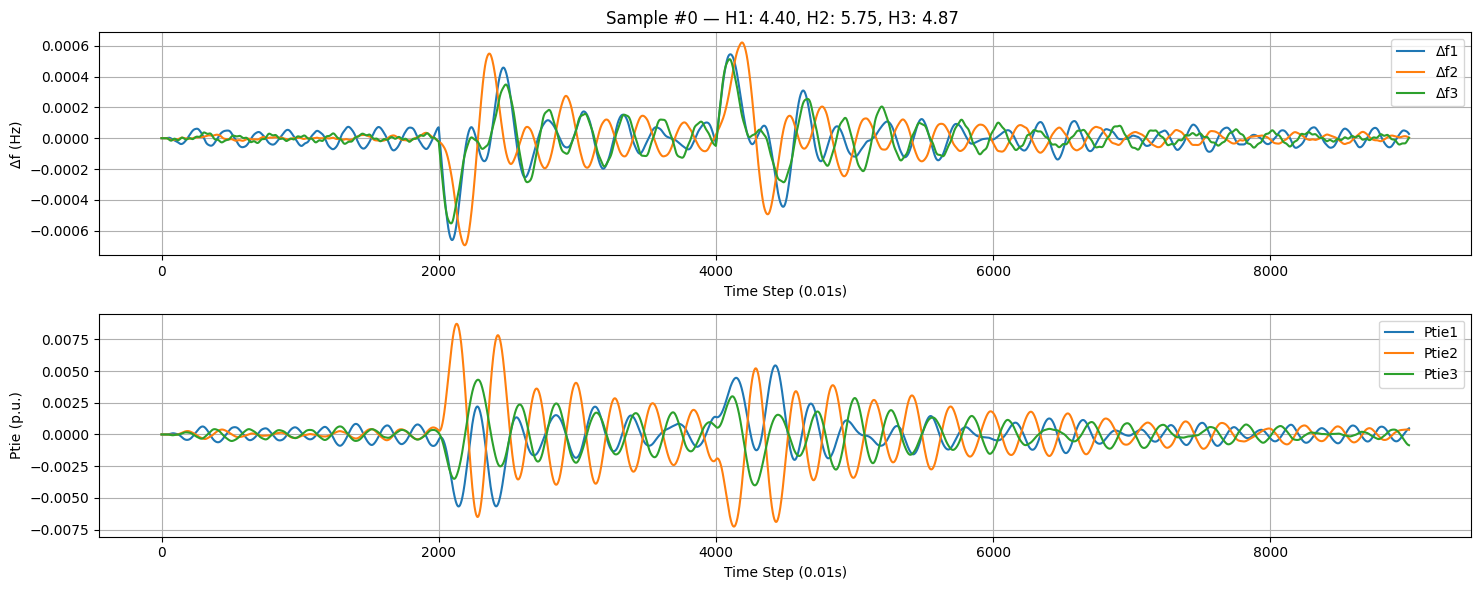

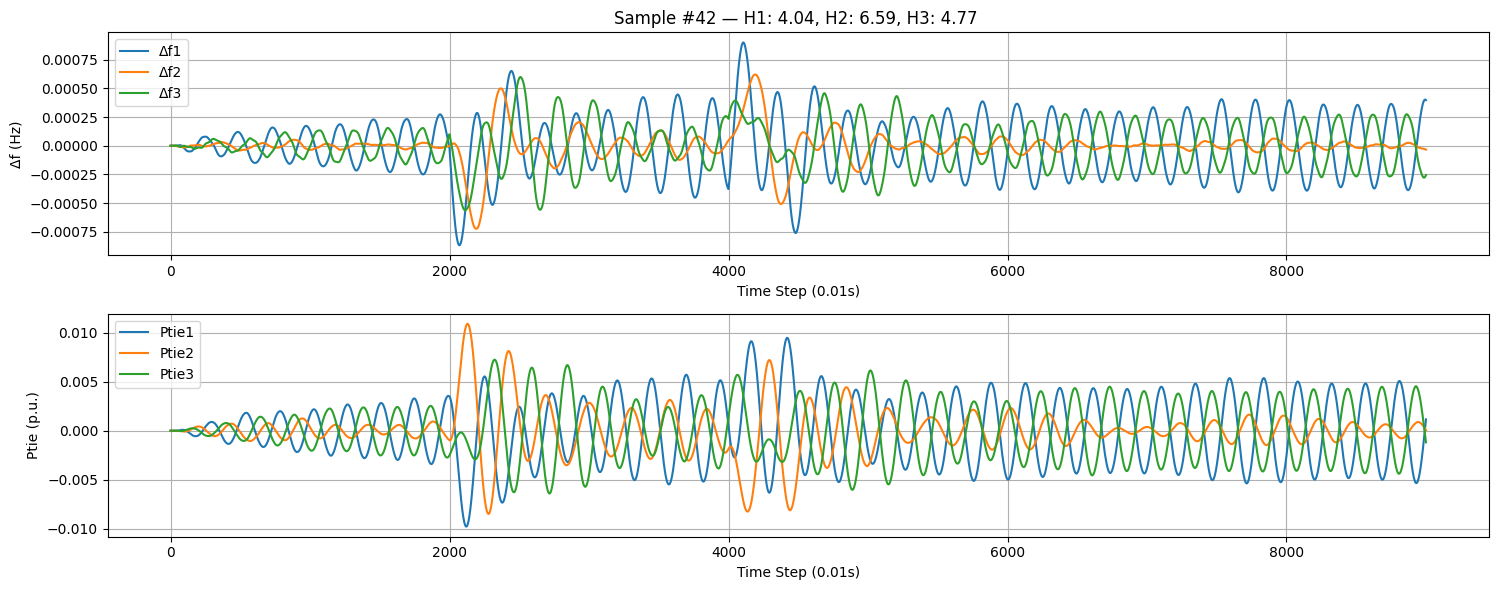

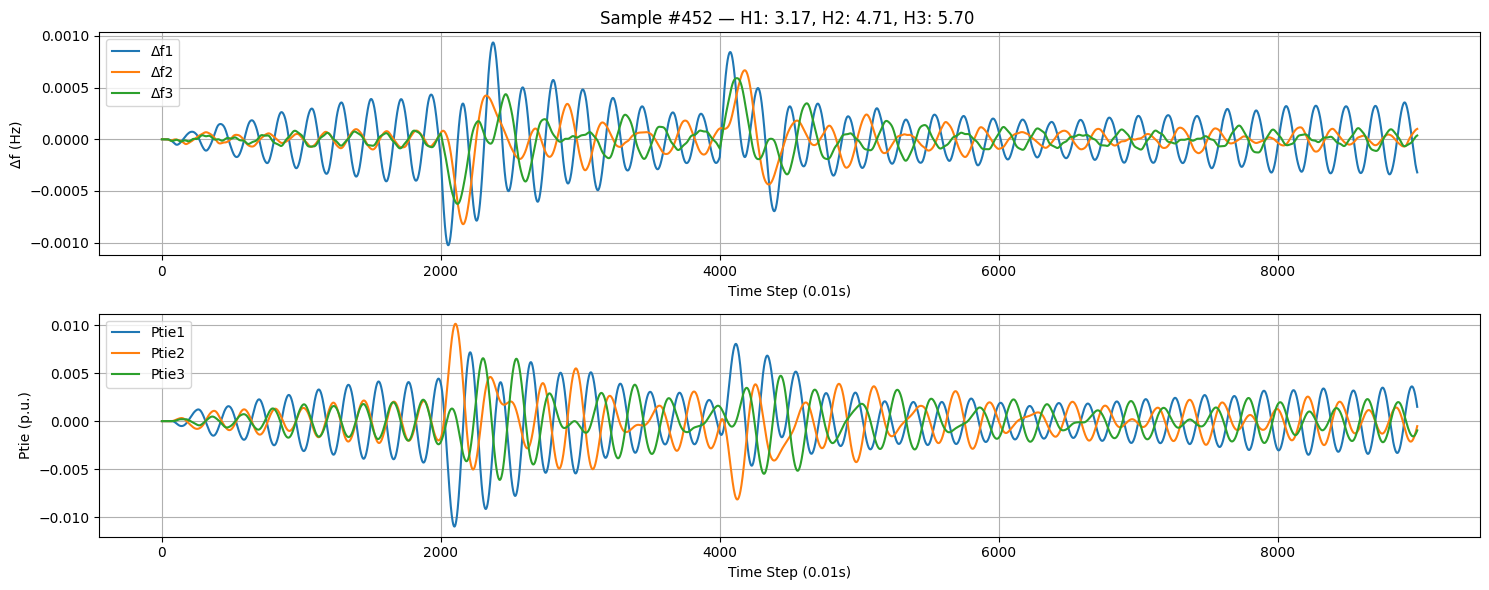

In [ ]:
plot_sample(0, X_old, Y_old)
plot_sample(42, X_old, Y_old)
plot_sample(452, X_old, Y_old)


In [1]:
import pandas as pd

Statistic_Data = pd.read_csv('simulink_features_3area_multisource_3sources.csv')

Statistic_Data.head(10)

,df1_mean,df1_std,df1_max,df1_min,df1_ptp,df1_rms,df1_max_rocof,df1_nadir_time,df1_rms_ratio,df2_mean,...,ptie3_max,ptie3_min,ptie3_ptp,ptie3_rms,ptie3_max_rocof,ptie3_nadir_time,ptie3_rms_ratio,H1,H2,H3
0,1.918179e-07,0.000128,0.000544,-0.000661,0.001205,0.000128,10005.359375,20.96,0.276925,1.568389e-07,...,0.004315,-0.004012,0.008326,0.001146,10011.016602,42.80,0.206257,4.395611,5.749354,4.868040
1,9.246919e-08,0.000125,0.000443,-0.000557,0.001000,0.000125,10004.466797,21.18,0.160552,-2.639625e-08,...,0.006745,-0.006634,0.013379,0.001371,10047.557617,42.62,0.082437,7.111508,7.304425,4.482156
2,2.071274e-07,0.000153,0.000608,-0.000681,0.001289,0.000153,10008.007812,21.06,0.155261,-1.477262e-07,...,0.005103,-0.005189,0.010292,0.001206,10252.185547,21.03,0.255895,5.079337,7.687594,3.321379
3,-1.398331e-06,0.000176,0.000409,-0.000583,0.000992,0.000176,10026.204102,20.98,1.661798,2.982438e-06,...,0.003034,-0.003458,0.006492,0.001409,10003.927734,44.61,3.027089,5.396433,3.426585,7.464596
4,1.614701e-07,0.000171,0.000791,-0.000668,0.001459,0.000171,10003.785156,44.76,0.139643,8.702937e-08,...,0.005647,-0.005466,0.011113,0.001225,10013.569336,20.98,0.178357,4.222416,6.556093,3.159393
5,-1.003747e-07,0.000120,0.000537,-0.000569,0.001106,0.000120,10470.927734,21.26,0.251630,1.867708e-07,...,0.006805,-0.006573,0.013378,0.001449,10012.093750,42.31,0.123657,6.893819,4.733584,3.713598
6,1.461350e-07,0.000152,0.000591,-0.000634,0.001225,0.000152,10440.992188,21.06,0.569663,-4.934868e-08,...,0.005215,-0.006970,0.012185,0.001792,10007.207031,43.45,0.415774,4.693238,7.628914,6.316062
7,-3.213343e-07,0.000134,0.000565,-0.000644,0.001209,0.000134,10003.007812,20.73,0.229593,-8.028830e-09,...,0.006231,-0.005953,0.012184,0.001351,10163.572266,42.85,0.207002,4.531565,6.895451,4.950662
8,-2.033682e-07,0.000126,0.000502,-0.000478,0.000979,0.000126,10008.737305,21.33,0.246091,3.488876e-08,...,0.005725,-0.006756,0.012481,0.001388,10001.724609,43.01,0.143988,7.926388,7.663967,6.187082
9,5.000999e-07,0.000150,0.000565,-0.000595,0.001160,0.000150,10001.337891,20.73,0.462761,-4.818129e-08,...,0.006975,-0.007069,0.014043,0.001814,19886.394531,42.93,0.410046,3.183630,6.605315,4.676195


In [2]:
Statistic_Data.columns

Index(['df1_mean', 'df1_std', 'df1_max', 'df1_min', 'df1_ptp', 'df1_rms',
       'df1_max_rocof', 'df1_nadir_time', 'df1_rms_ratio', 'df2_mean',
       'df2_std', 'df2_max', 'df2_min', 'df2_ptp', 'df2_rms', 'df2_max_rocof',
       'df2_nadir_time', 'df2_rms_ratio', 'df3_mean', 'df3_std', 'df3_max',
       'df3_min', 'df3_ptp', 'df3_rms', 'df3_max_rocof', 'df3_nadir_time',
       'df3_rms_ratio', 'ptie1_mean', 'ptie1_std', 'ptie1_max', 'ptie1_min',
       'ptie1_ptp', 'ptie1_rms', 'ptie1_max_rocof', 'ptie1_nadir_time',
       'ptie1_rms_ratio', 'ptie2_mean', 'ptie2_std', 'ptie2_max', 'ptie2_min',
       'ptie2_ptp', 'ptie2_rms', 'ptie2_max_rocof', 'ptie2_nadir_time',
       'ptie2_rms_ratio', 'ptie3_mean', 'ptie3_std', 'ptie3_max', 'ptie3_min',
       'ptie3_ptp', 'ptie3_rms', 'ptie3_max_rocof', 'ptie3_nadir_time',
       'ptie3_rms_ratio', 'H1', 'H2', 'H3'],
      dtype='object')

Because we estimated wrongly the rocof values we drop them form our dataset

In [3]:
import pandas as pd
df = pd.read_csv("simulink_features_3area_multisource_3sources.csv")
rocof_cols = [c for c in df.columns if c.endswith("_max_rocof")]
df_clean = df.drop(columns=rocof_cols)  # προτείνεται να πετάξεις και το ptie_max_rocof αν υπάρχει
df_clean.to_csv("simulink_features_3area_multisource_3sources_FINAL.csv", index=False)
print("Έτοιμο: simulink_features_3area_multisource_3sources_FINAL.csv")


Έτοιμο: simulink_features_3area_multisource_3sources_FINAL.csv


In [4]:
df = df_clean.copy()

In [5]:
df.shape

(1000, 51)

In [7]:
df.columns

Index(['df1_mean', 'df1_std', 'df1_max', 'df1_min', 'df1_ptp', 'df1_rms',
       'df1_nadir_time', 'df1_rms_ratio', 'df2_mean', 'df2_std', 'df2_max',
       'df2_min', 'df2_ptp', 'df2_rms', 'df2_nadir_time', 'df2_rms_ratio',
       'df3_mean', 'df3_std', 'df3_max', 'df3_min', 'df3_ptp', 'df3_rms',
       'df3_nadir_time', 'df3_rms_ratio', 'ptie1_mean', 'ptie1_std',
       'ptie1_max', 'ptie1_min', 'ptie1_ptp', 'ptie1_rms', 'ptie1_nadir_time',
       'ptie1_rms_ratio', 'ptie2_mean', 'ptie2_std', 'ptie2_max', 'ptie2_min',
       'ptie2_ptp', 'ptie2_rms', 'ptie2_nadir_time', 'ptie2_rms_ratio',
       'ptie3_mean', 'ptie3_std', 'ptie3_max', 'ptie3_min', 'ptie3_ptp',
       'ptie3_rms', 'ptie3_nadir_time', 'ptie3_rms_ratio', 'H1', 'H2', 'H3'],
      dtype='object')

#Preprocess

## CHECKING FOR INSTABILITY INPUT SEQUENCES

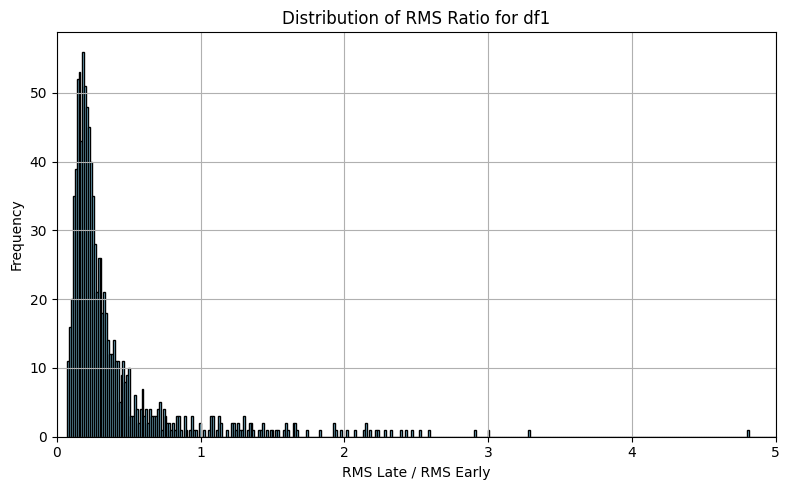

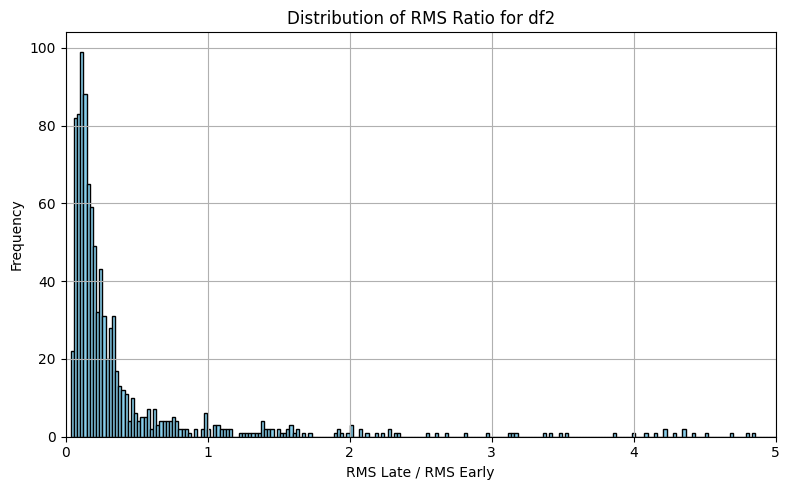

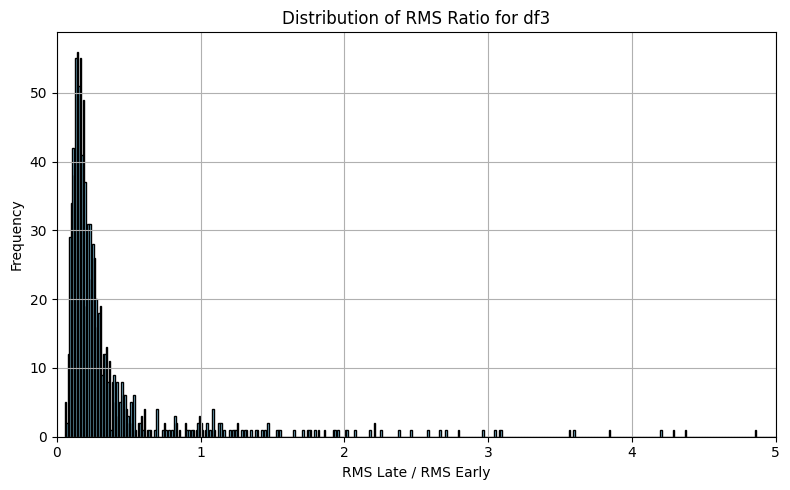

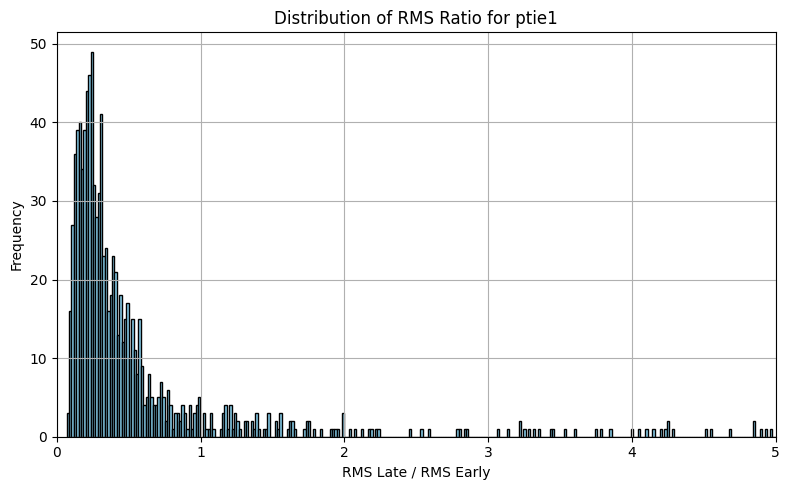

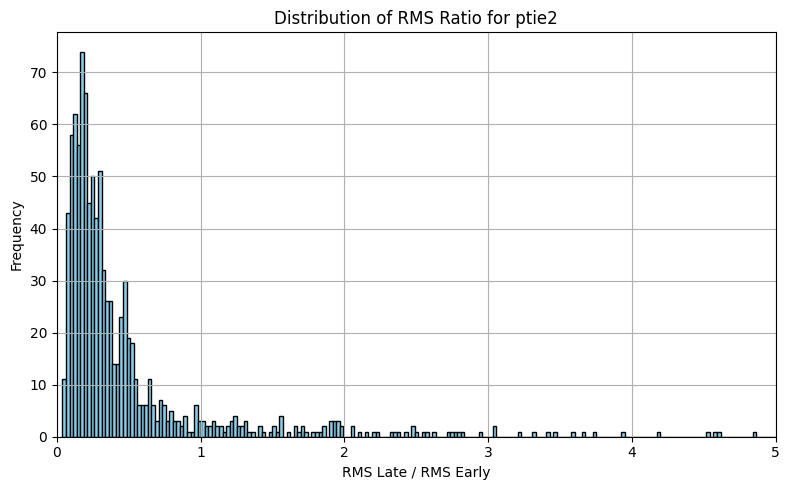

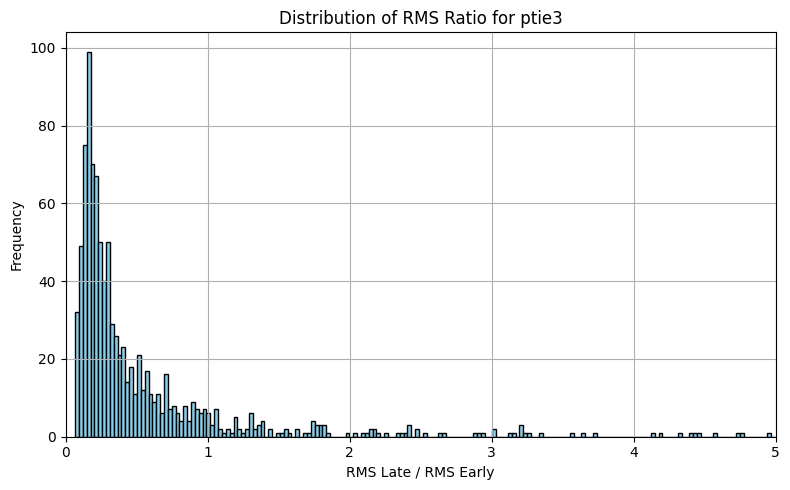

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your new dataset
# df = pd.read_csv('simulink_features_3area_multisource.csv')

channels = ['df1', 'df2', 'df3', 'ptie1', 'ptie2', 'ptie3']

for channel in channels:
    plt.figure(figsize=(8, 5))
    plt.hist(df[f'{channel}_rms_ratio'], bins=500, color='skyblue', edgecolor='k')
    plt.title(f'Distribution of RMS Ratio for {channel}')
    plt.xlabel('RMS Late / RMS Early')
    plt.ylabel('Frequency')
    plt.xlim(0, 5)  # Adjust as needed depending on your data
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Shape of X after loading and converting for plotting: torch.Size([1000, 9001, 6])
Found 75 sequences with RMS ratio > 2.5


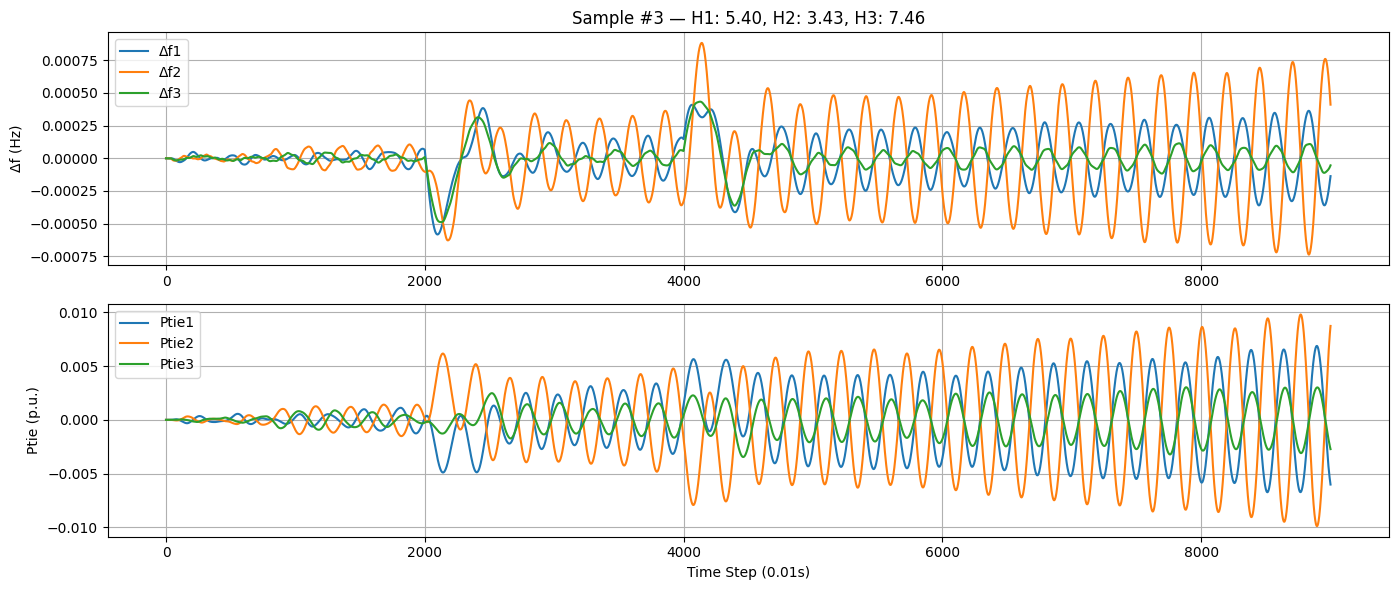

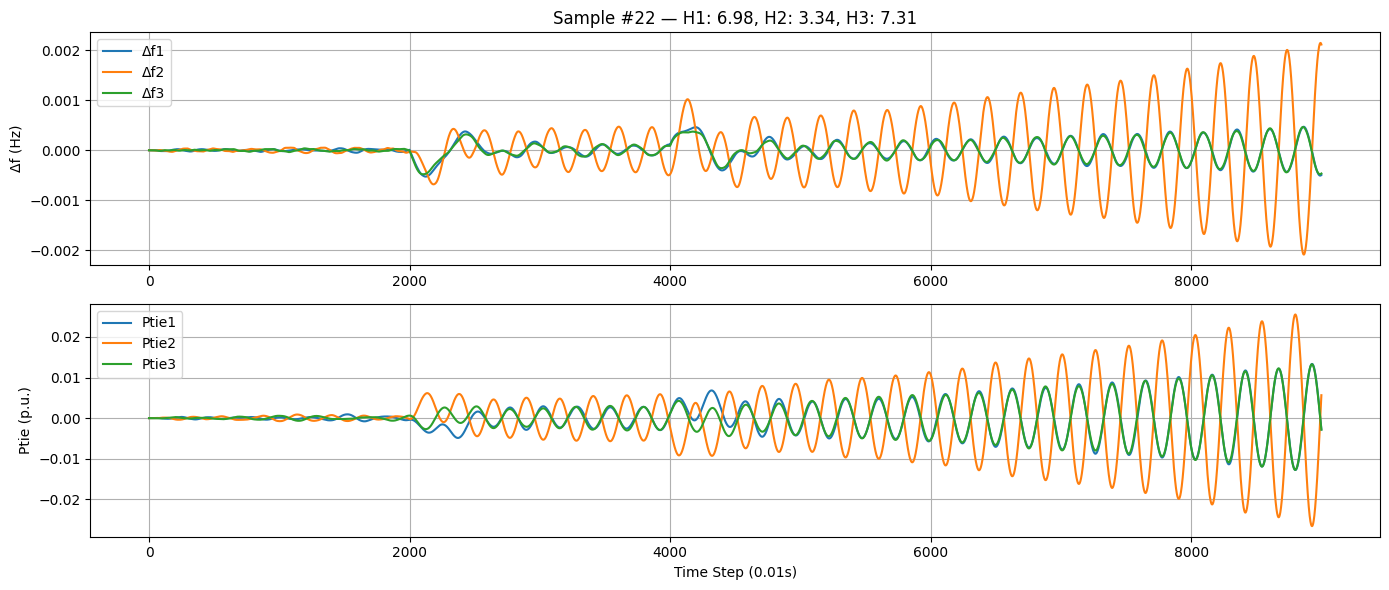

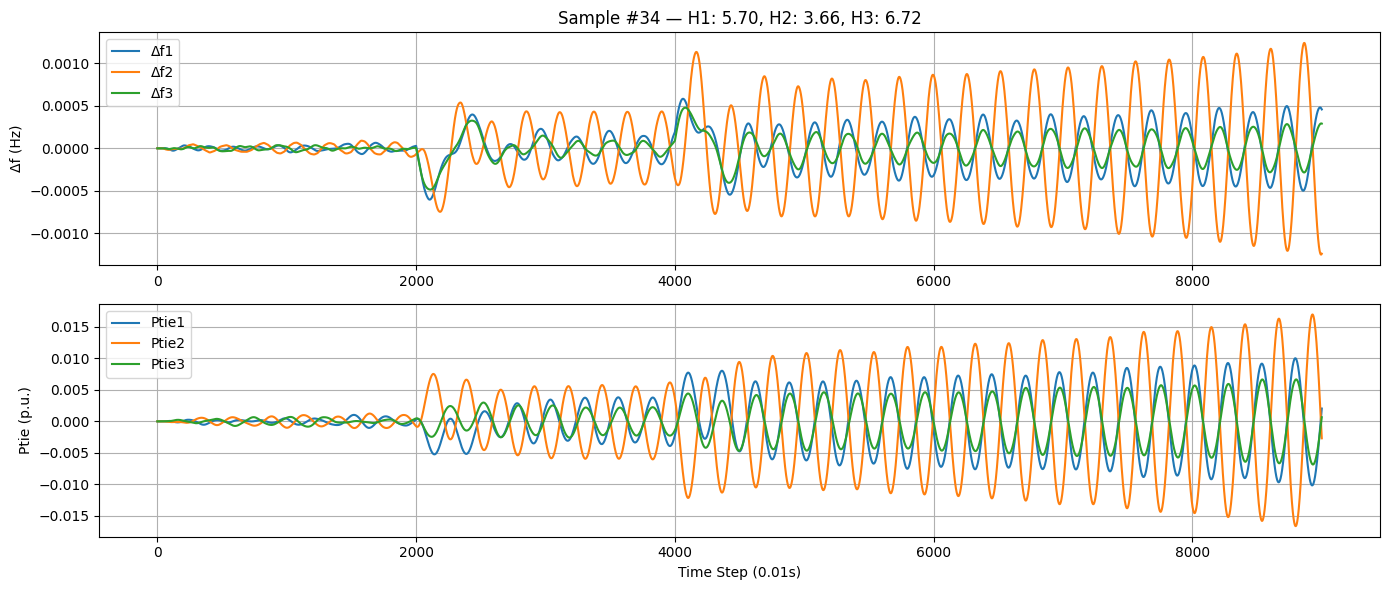

In [ ]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === Load new data and features ===
with h5py.File('simulink_dataset_3area_multisource_3sources.mat', 'r') as f:
    # Load data and transpose to get shape (samples, time_steps, channels)
    all_data = f['all_data'][:].transpose(2, 1, 0) # Original: (channels, time_steps, samples) -> Transposed: (samples, time_steps, channels)

# Convert to PyTorch Tensor with the correct shape
X = torch.tensor(all_data, dtype=torch.float32)  # shape should now be (1000, 9001, 6)

# Load features
df = pd.read_csv('simulink_features_3area_multisource_3sources.csv')

# Verify the shape of X after correction
print(f"Shape of X after loading and converting for plotting: {X.shape}")

# === Define channel names ===
channels = ['df1', 'df2', 'df3', 'ptie1', 'ptie2', 'ptie3']
# Use channel names for plotting labels directly
freq_channels_names = ['Δf1', 'Δf2', 'Δf3']
tie_channels_names = ['Ptie1', 'Ptie2', 'Ptie3']


# === Select samples with high RMS ratio for any signal ===
threshold = 2.5
condition = False
for ch in channels:
    condition |= (df[f'{ch}_rms_ratio'] > threshold)

high_ratio_idx = df[condition].index

print(f"Found {len(high_ratio_idx)} sequences with RMS ratio > {threshold}")

# === Plot a few high-ratio sequences ===
for idx in high_ratio_idx[:3]: # Plotting the first 3 found unstable sequences
    h1_val = df.loc[idx, 'H1']
    h2_val = df.loc[idx, 'H2']
    h3_val = df.loc[idx, 'H3']

    plt.figure(figsize=(14, 6))

    # Frequency subplot
    plt.subplot(2, 1, 1)
    # Now access is X[sample_index, time_step, channel_index]
    for j, name in enumerate(freq_channels_names):
        plt.plot(X[idx, :, j], label=name) # X[sample_idx, all_time_steps, freq_channel_idx]
    plt.title(f"Sample #{idx} — H1: {h1_val:.2f}, H2: {h2_val:.2f}, H3: {h3_val:.2f}")
    plt.ylabel("Δf (Hz)")
    plt.legend()
    plt.grid(True)

    # Ptie subplot
    plt.subplot(2, 1, 2)
    # Ptie channels start from index 3 in the original data
    for j, name in enumerate(tie_channels_names):
         plt.plot(X[idx, :, j + 3], label=name) # X[sample_idx, all_time_steps, tie_channel_idx + 3]
    plt.xlabel("Time Step (0.01s)")
    plt.ylabel("Ptie (p.u.)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd

# df = pd.read_csv('simulink_features_3area_multisource.csv')

threshold = 2.5
channels = ['df1', 'df2', 'df3', 'ptie1', 'ptie2', 'ptie3']

# Count how many sequences exceed the threshold per channel
unstable_counts = {
    channel: (df[f'{channel}_rms_ratio'] > threshold).sum()
    for channel in channels
}

# Total number of sequences unstable in any channel
total_unstable = df[[f'{ch}_rms_ratio' for ch in channels]].gt(threshold).any(axis=1).sum()

# === Print Results ===
print(f"Number of unstable sequences with RMS ratio > {threshold}:")
for ch, count in unstable_counts.items():
    print(f"  {ch}: {count}")

print(f"Total (any channel): {total_unstable}")


Number of unstable sequences with RMS ratio > 2.5:
  df1: 7
  df2: 56
  df3: 16
  ptie1: 55
  ptie2: 68
  ptie3: 67
Total (any channel): 75


In [ ]:
# Define stable RMS ratio threshold
threshold = 2.5

# List of all 6 signal names
channels = ['df1', 'df2', 'df3', 'ptie1', 'ptie2', 'ptie3']

# Apply filtering: keep only rows where all channels have RMS ratio <= threshold
df = df[
    df[[f'{ch}_rms_ratio' for ch in channels]].le(threshold).all(axis=1)
]

print(f"Filtered DataFrame shape: {df.shape}")


Filtered DataFrame shape: (925, 51)


## dropping the rms ratio colums

In [ ]:
# # Drop all *_rms_ratio columns
# df = df.drop(columns=[f'{ch}_rms_ratio' for ch in ['df1', 'df2', 'df3', 'ptie1', 'ptie2', 'ptie3']])


In [ ]:
df.shape

(925, 51)

#CORRATION MATRIX

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def filter_features_by_correlation(df, target_columns=['H1', 'H2', 'H3'], threshold=0.3,
                                   verbose=True, plot_corr=True, figsize=(12, 8),
                                   return_corr_matrix=False):
    """
    Filter features based on their absolute correlation with target columns.

    Parameters:
    - df: pandas DataFrame containing both features and targets
    - target_columns: list of target column names (default ['H1', 'H2', 'H3'])
    - threshold: minimum absolute correlation to keep a feature (default 0.3)
    - verbose: whether to print the correlation results (default True)
    - plot_corr: whether to plot the correlation heatmap (default True)
    - figsize: size of the correlation plot (default (12, 8))
    - return_corr_matrix: if True, also return full correlation matrix

    Returns:
    - DataFrame with selected features + targets
    - List of selected feature names
    - (Optional) Correlation matrix
    """
    # === Step 1: Compute correlation matrix ===
    corr_matrix = df.corr().abs()

    # === Step 2: Extract correlations with only the target columns ===
    feature_corr = corr_matrix[target_columns].drop(index=target_columns, errors='ignore')

    if verbose:
        print("🔍 Correlation of features with targets:\n")
        print(feature_corr)

    # === Step 3: Optional Heatmap ===
    if plot_corr:
        plt.figure(figsize=figsize)
        sns.heatmap(feature_corr, annot=True, cmap='coolwarm',
                    vmin=0, vmax=1, linewidths=0.5, fmt=".2f")
        plt.title(f"Absolute Correlation with Targets (Threshold = {threshold})")
        plt.tight_layout()
        plt.show()

    # === Step 4: Select features exceeding threshold for any target ===
    mask = (feature_corr > threshold).any(axis=1)
    eliminated_features = feature_corr[~mask].index.tolist()
    if verbose:
        print(f"\n❌ Eliminated features (|correlation| <= {threshold}):")
        for feat in eliminated_features:
            print(f" - {feat}")
    selected_features = feature_corr[mask].index.tolist()

    if verbose:
        print(f"\n✅ Selected features (|correlation| > {threshold}):")
        for feat in selected_features:
            print(f" - {feat}")

    # === Step 5: Return filtered DataFrame and selected features ===
    result_df = df[selected_features + target_columns]

    if return_corr_matrix:
        return result_df, selected_features, corr_matrix
    else:
        return result_df, selected_features


🔍 Correlation of features with targets:

                        H1        H2        H3
df1_mean          0.025121  0.029143  0.060941
df1_std           0.523937  0.197972  0.054726
df1_max           0.572789  0.201556  0.175233
df1_min           0.702811  0.122445  0.223440
df1_ptp           0.688930  0.182343  0.214820
df1_rms           0.523933  0.197973  0.054725
df1_nadir_time    0.176856  0.076974  0.069078
df1_rms_ratio     0.362848  0.365045  0.086537
df2_mean          0.005585  0.090039  0.022799
df2_std           0.112810  0.515774  0.077575
df2_max           0.240180  0.417009  0.238953
df2_min           0.399247  0.663601  0.262452
df2_ptp           0.344748  0.585651  0.284172
df2_rms           0.112807  0.515773  0.077577
df2_nadir_time    0.014780  0.028576  0.058590
df2_rms_ratio     0.064734  0.559841  0.139038
df3_mean          0.047833  0.045402  0.002785
df3_std           0.360850  0.256373  0.387960
df3_max           0.304429  0.184361  0.566587
df3_min           0

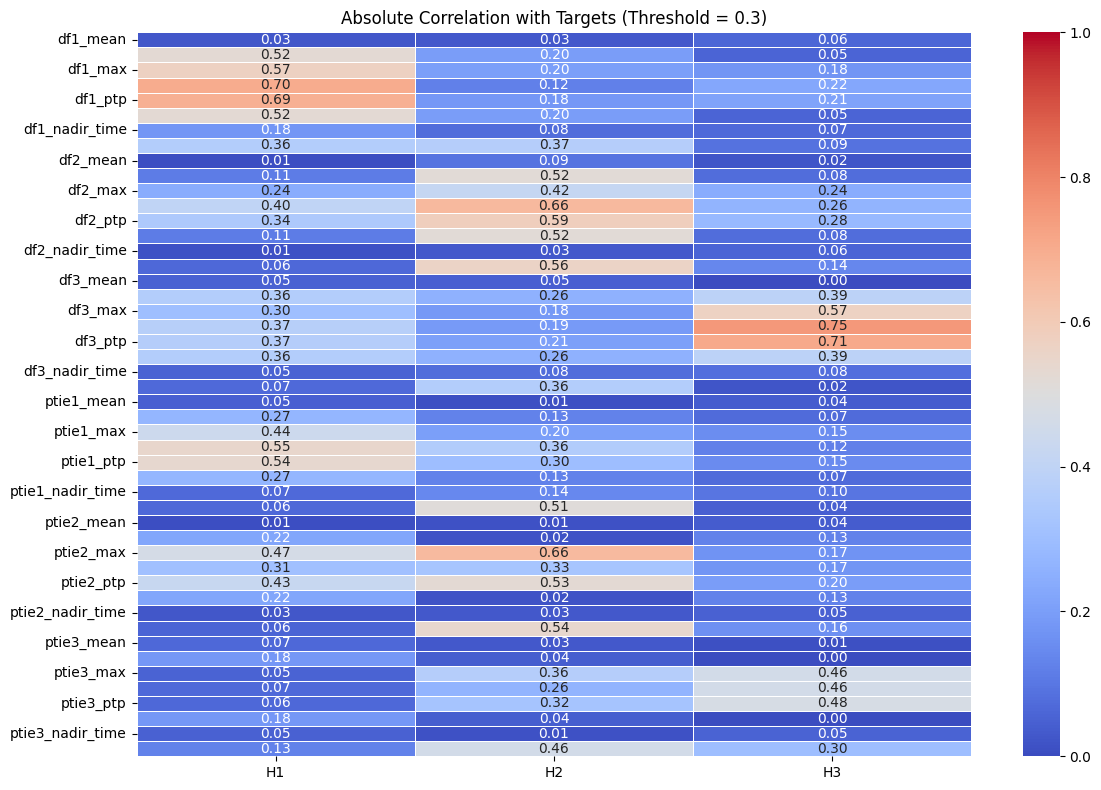


❌ Eliminated features (|correlation| <= 0.3):
 - df1_mean
 - df1_nadir_time
 - df2_mean
 - df2_nadir_time
 - df3_mean
 - df3_nadir_time
 - ptie1_mean
 - ptie1_std
 - ptie1_rms
 - ptie1_nadir_time
 - ptie2_mean
 - ptie2_std
 - ptie2_rms
 - ptie2_nadir_time
 - ptie3_mean
 - ptie3_std
 - ptie3_rms
 - ptie3_nadir_time

✅ Selected features (|correlation| > 0.3):
 - df1_std
 - df1_max
 - df1_min
 - df1_ptp
 - df1_rms
 - df1_rms_ratio
 - df2_std
 - df2_max
 - df2_min
 - df2_ptp
 - df2_rms
 - df2_rms_ratio
 - df3_std
 - df3_max
 - df3_min
 - df3_ptp
 - df3_rms
 - df3_rms_ratio
 - ptie1_max
 - ptie1_min
 - ptie1_ptp
 - ptie1_rms_ratio
 - ptie2_max
 - ptie2_min
 - ptie2_ptp
 - ptie2_rms_ratio
 - ptie3_max
 - ptie3_min
 - ptie3_ptp
 - ptie3_rms_ratio


In [ ]:
# Filter features
df_filtered, selected_features = filter_features_by_correlation(
    df,
    threshold=0.3,
    verbose=True,
    plot_corr=True
)



In [ ]:
df_filtered.shape

(925, 33)

#EVALUATION

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluate_predictions(Y_true, Y_pred, names=['H1', 'H2', 'H3'], verbose=True):
    """
    Evaluate predictions using R², MAE, RMSE, MAPE for each target variable.

    Parameters:
    - Y_true: numpy array or tensor of shape (N, D)
    - Y_pred: same shape as Y_true
    - names: list of names for each target output
    - verbose: print formatted output (default: True)

    Returns:
    - results: dictionary of metrics per target
    """
    results = {}

    for i, name in enumerate(names):
        true = Y_true[:, i]
        pred = Y_pred[:, i]

        metrics = {
            'R2': r2_score(true, pred),
            'MAE': mean_absolute_error(true, pred),
            'RMSE': np.sqrt(mean_squared_error(true, pred)),
            'MAPE': mean_absolute_percentage_error(true, pred) * 100
        }

        results[name] = metrics

        if verbose:
            print(f"{name} → R²: {metrics['R2']:.5f}, RMSE: {metrics['RMSE']:.5f}, "
                  f"MAE: {metrics['MAE']:.5f}, MAPE: {metrics['MAPE']:.2f}%")

    return results


#COMPARASION DATAFRAME

In [ ]:
import pandas as pd

def create_comparison_df(Y_true, Y_pred, names=['H1', 'H2', 'H3']):
    """
    Create a DataFrame comparing actual and predicted values.

    Parameters:
    - Y_true: numpy array or tensor of shape (N, D) with true values
    - Y_pred: numpy array or tensor of shape (N, D) with predicted values
    - names: list of output variable names (default ['H1', 'H2', 'H3'])

    Returns:
    - Pandas DataFrame with columns: H1_actual, H1_pred, ..., H3_pred
    """
    data = {}
    for i, name in enumerate(names):
        data[f'{name}_actual'] = Y_true[:, i]
        data[f'{name}_pred'] = Y_pred[:, i]

    return pd.DataFrame(data)


#PLOTTER OF ESTIMATIONS

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_predictions(Y_true, Y_pred, target_names=['H1', 'H2', 'H3'],
                     figsize=(15, 5), alpha=0.6, color='b',
                     diagonal_line=True, grid=True, tight_layout=True):
    """
    Create actual vs. predicted scatter plots for multiple targets.

    Parameters:
    - Y_true: 2D array [n_samples, n_targets] with true values
    - Y_pred: same shape as Y_true, predicted values
    - target_names: List of target names (default ['H1', 'H2', 'H3'])
    - figsize: Tuple (width, height) for the whole figure
    - alpha: Scatter point transparency
    - color: Scatter point color
    - diagonal_line: If True, plots y = x line
    - grid: If True, shows gridlines
    - tight_layout: If True, adjusts spacing

    Returns:
    - Matplotlib figure object
    """
    n_targets = Y_true.shape[1]
    fig, axes = plt.subplots(1, n_targets, figsize=figsize)

    if n_targets == 1:
        axes = [axes]  # Ensure iterable

    for i, ax in enumerate(axes):
        true = Y_true[:, i]
        pred = Y_pred[:, i]

        # Scatter plot
        ax.scatter(true, pred, alpha=alpha, color=color)

        # R² score
        r2 = r2_score(true, pred)

        # Diagonal line
        if diagonal_line:
            min_val = min(true.min(), pred.min())
            max_val = max(true.max(), pred.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')

        # Labels and title
        ax.set_xlabel(f"True {target_names[i]}")
        ax.set_ylabel(f"Predicted {target_names[i]}")
        ax.set_title(f"{target_names[i]} Prediction\nR² = {r2:.3f}")

        if grid:
            ax.grid(True)
        if diagonal_line:
            ax.legend()

    if tight_layout:
        plt.tight_layout()

    return fig


#BOXPLOT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_error_analysis(Y_true, Y_pred, target_names=['H1', 'H2', 'H3'],
                        plot_type='boxplot', figsize=(10, 6),
                        show_stats=True, palette='Set2'):
    """
    Visualize prediction errors for each target using boxplots, violins, or both.

    Parameters:
    - Y_true: np.array of true values, shape (N, D)
    - Y_pred: np.array of predicted values, shape (N, D)
    - target_names: list of strings for each target (default ['H1', 'H2', 'H3'])
    - plot_type: 'boxplot', 'violin', or 'combined'
    - figsize: matplotlib figure size
    - show_stats: whether to print error statistics
    - palette: seaborn color palette

    Returns:
    - fig: matplotlib figure object
    - stats: dictionary of summary error metrics
    """
    errors = np.abs(Y_pred - Y_true)
    stats = {}

    # Compute stats
    for i, name in enumerate(target_names):
        stats[name] = {
            'mean_error': np.mean(errors[:, i]),
            'median_error': np.median(errors[:, i]),
            'max_error': np.max(errors[:, i]),
            'std_dev': np.std(errors[:, i])
        }

    if show_stats:
        print("📊 Error Statistics:")
        for name in target_names:
            s = stats[name]
            print(f"\n{name}:")
            print(f"  Mean Absolute Error: {s['mean_error']:.4f}")
            print(f"  Median Absolute Error: {s['median_error']:.4f}")
            print(f"  Max Error: {s['max_error']:.4f}")
            print(f"  Standard Deviation: {s['std_dev']:.4f}")

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot types
    plot_data = [errors[:, i] for i in range(len(target_names))]
    colors = sns.color_palette(palette, len(target_names))

    if plot_type == 'boxplot':
        bp = ax.boxplot(plot_data, labels=[f'{name} Error' for name in target_names], patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

    elif plot_type == 'violin':
        vp = ax.violinplot(plot_data, showmedians=True)
        for pc, color in zip(vp['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
        ax.set_xticks(np.arange(1, len(target_names) + 1))
        ax.set_xticklabels([f'{name} Error' for name in target_names])

    elif plot_type == 'combined':
        positions = np.arange(1, len(target_names) + 1)
        # Violin
        vp = ax.violinplot(plot_data, positions=positions - 0.15, widths=0.3, showmedians=True)
        # Box
        bp = ax.boxplot(plot_data, positions=positions + 0.15, widths=0.2, patch_artist=True)

        for pc, color in zip(vp['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_alpha(0.5)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax.set_xticks(positions)
        ax.set_xticklabels([f'{name} Error' for name in target_names])

    ax.set_ylabel('Absolute Error')
    ax.set_title('Prediction Error Analysis')
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    return fig, stats


#CDF PLOTTER

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List, Dict, Optional

# This function plots the CDF of multiple datasets provided in a dictionary.
def plot_cdf(data_dict: dict, title: str = 'CDF Plot', xlabel: str = 'Values',
             ylabel: str = 'Cumulative Probability', figsize=(8, 6), grid=True) -> plt.Figure:
    """
    Plots the Cumulative Distribution Function (CDF) for multiple datasets.

    Parameters:
    - data_dict: Dictionary where keys are labels and values are arrays of data.
    - title: Title of the plot.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - figsize: Figure size.
    - grid: Whether to show grid.

    Returns:
    - matplotlib Figure object
    """
    fig, ax = plt.subplots(figsize=figsize)

    for label, data in data_dict.items():
        # Filter out NaN/inf just in case
        data = data[np.isfinite(data)]
        if len(data) == 0:
            print(f"Warning: No finite data for label '{label}'. Skipping.")
            continue

        sorted_data = np.sort(data)
        # Calculate CDF as the empirical CDF
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        ax.plot(sorted_data, cdf, label=label)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    if grid:
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    return fig

# The plot_error_cdfs function remains the same, as it now calls the correctly
# structured plot_cdf function.
def plot_error_cdfs(Y_true: np.ndarray,
                   Y_pred: np.ndarray,
                   target_names: Optional[List[str]] = None,
                   **kwargs) -> plt.Figure:
    """
    Calculate absolute errors and plot their CDFs using the generic plot_cdf function.

    Parameters:
    - Y_true: Array of true values (shape [n_samples, n_targets])
    - Y_pred: Array of predicted values (same shape as Y_true)
    - target_names: Optional list of target names
    - **kwargs: Additional arguments for plot_cdf()

    Returns:
    - matplotlib Figure object
    """
    # Calculate absolute errors for each target
    errors = np.abs(Y_pred - Y_true)

    # Default target names
    if target_names is None:
        target_names = [f'Target {i+1}' for i in range(Y_true.shape[1])]
    elif len(target_names) != Y_true.shape[1]:
         print(f"Warning: target_names length ({len(target_names)}) does not match number of targets ({Y_true.shape[1]}). Using default names.")
         target_names = [f'Target {i+1}' for i in range(Y_true.shape[1])]


    # Create error dictionary for the generic plotter
    error_dict = {f'{name} Error': errors[:, i]
                 for i, name in enumerate(target_names)}

    # Plot using the generic CDF function
    # Pass the error_dict and any extra kwargs
    return plot_cdf(error_dict, xlabel='Absolute Error', title='CDF of Absolute Prediction Errors', **kwargs)

# Now you can use it like this (this part is unchanged):
# fig = plot_error_cdfs(Y_test, Y_pred, target_names=['H1', 'H2'])

#SPLITTING AND SCALING

In [ ]:
X = df_filtered.iloc[:, :-3].values
Y = df_filtered.iloc[:, -3:].values

print(X.shape)
print(Y.shape)


(925, 30)
(925, 3)


In [ ]:
from sklearn.model_selection import train_test_split

# === Train/test split ===
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Y_train_scaled = scaler.fit_transform(Y_train)
Y_test_scaled = scaler.transform(Y_test)

#ESTIMATION MODELS






##RANDOM FOREST

In [ ]:
# === Train random forest ===

from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, Y_train_scaled)

# === Predict and evaluate ===
Y_pred_scaled = rf.predict(X_test_scaled)


Y_pred = scaler.inverse_transform(Y_pred_scaled)
Y_true = scaler.inverse_transform(Y_test_scaled)

In [ ]:
# Example usage:
results = evaluate_predictions(Y_true, Y_pred)

H1 → R²: 0.86414, RMSE: 0.52118, MAE: 0.39646, MAPE: 7.79%
H2 → R²: 0.90435, RMSE: 0.43897, MAE: 0.33079, MAPE: 6.64%
H3 → R²: 0.84969, RMSE: 0.56886, MAE: 0.42812, MAPE: 8.80%


In [ ]:
# Example usage:
comparison_df = create_comparison_df(Y_test, Y_pred)
print(comparison_df)

     H1_actual   H1_pred  H2_actual   H2_pred  H3_actual   H3_pred
0     3.869904  4.562807   4.984047  5.308187   5.116563  5.850083
1     3.823586  3.988906   6.780290  6.498840   5.133340  5.771872
2     3.215969  3.589542   7.284226  6.985655   4.031593  4.231087
3     3.194046  5.232500   3.170431  4.025583   3.597011  4.096198
4     6.743159  6.999717   3.948263  4.949677   5.740581  6.270705
..         ...       ...        ...       ...        ...       ...
273   7.605381  6.356480   3.441800  5.045665   5.624078  6.932441
274   5.147789  5.115878   5.930243  6.049719   6.912173  6.281152
275   3.794412  3.584081   4.013303  4.253081   6.461412  6.685854
276   6.395177  6.104351   5.286602  5.207407   4.258512  4.337742
277   5.210386  4.634614   5.340061  5.539633   3.470449  4.154321

[278 rows x 6 columns]


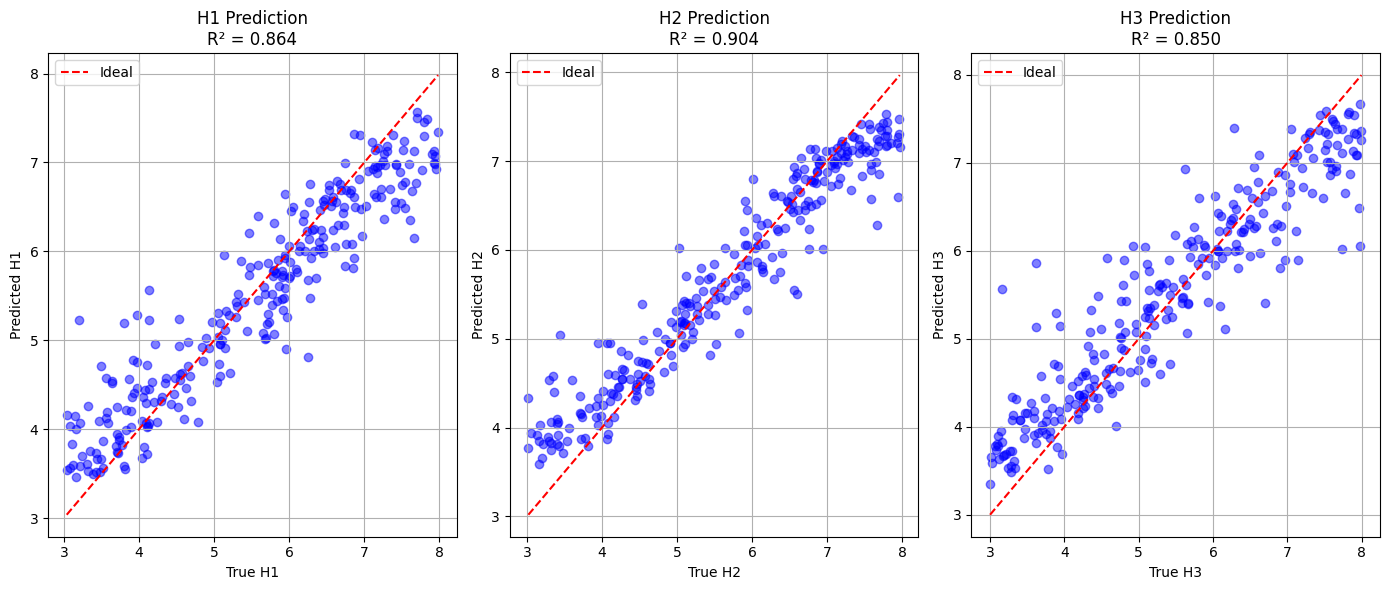

In [ ]:
# Customized plot
fig = plot_predictions(Y_test, Y_pred,
                      target_names=['H1', 'H2','H3'],
                      figsize=(14, 6),
                      alpha=0.5,
                      color='blue')

📊 Error Statistics:

H1:
  Mean Absolute Error: 0.3965
  Median Absolute Error: 0.3041
  Max Error: 2.0385
  Standard Deviation: 0.3383

H2:
  Mean Absolute Error: 0.3308
  Median Absolute Error: 0.2491
  Max Error: 1.6039
  Standard Deviation: 0.2886

H3:
  Mean Absolute Error: 0.4281
  Median Absolute Error: 0.3064
  Max Error: 2.4081
  Standard Deviation: 0.3746


/tmp/ipython-input-3884306860.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=[f'{name} Error' for name in target_names], patch_artist=True)


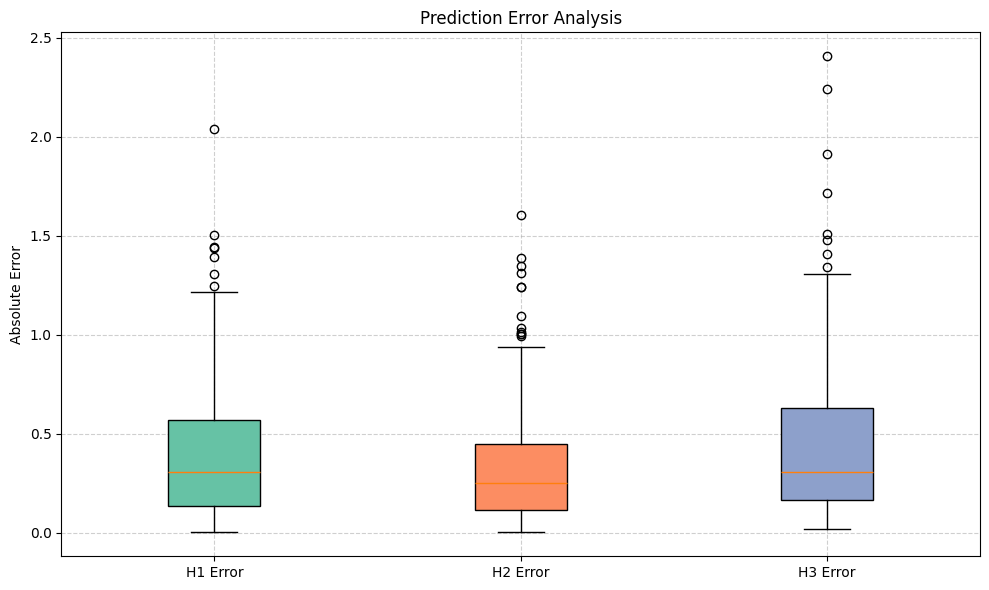

In [ ]:
# Basic boxplot
fig, stats = plot_error_analysis(Y_test, Y_pred)

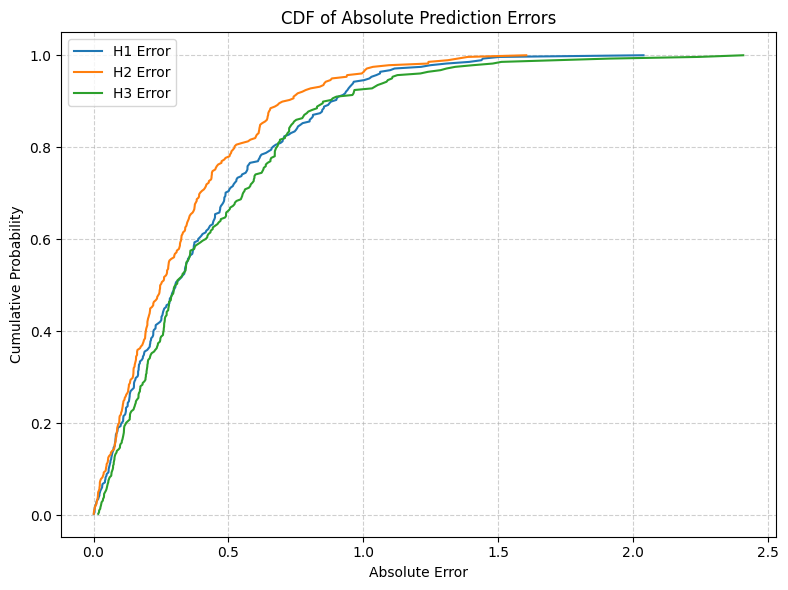

In [ ]:
fig = plot_error_cdfs(Y_test, Y_pred, target_names=['H1', 'H2','H3'])

| **Absolute Error (x)** | **Cumulative Probability (y)** | **Interpretation**                   |
| ---------------------- | ------------------------------ | ------------------------------------ |
| 0.05                   | 0.40                           | 40% of predictions have error ≤ 0.05 |
| 0.10                   | 0.75                           | 75% of predictions have error ≤ 0.10 |
| 0.20                   | 0.90                           | 90% of predictions have error ≤ 0.20 |
| 0.40                   | 0.98                           | 98% of predictions have error ≤ 0.40 |
| 1.00                   | 1.00                           | 100% of predictions have error ≤ 1.0 |


#LINEAR REGRESSION

H1 → R²: 0.72639, RMSE: 0.73961, MAE: 0.53768, MAPE: 11.23%
H2 → R²: 0.96251, RMSE: 0.27483, MAE: 0.20851, MAPE: 4.10%
H3 → R²: 0.75632, RMSE: 0.72430, MAE: 0.54063, MAPE: 11.04%
-------------------------------------------
     H1_actual   H1_pred  H2_actual   H2_pred  H3_actual   H3_pred
0     3.869904  4.061790   4.984047  4.795810   5.116563  6.096238
1     3.823586  3.744659   6.780290  7.002421   5.133340  5.938484
2     3.215969  2.862515   7.284226  7.400275   4.031593  4.713515
3     3.194046  5.931229   3.170431  1.956949   3.597011  0.427743
4     6.743159  7.380363   3.948263  3.930657   5.740581  7.379819
..         ...       ...        ...       ...        ...       ...
273   7.605381  7.830947   3.441800  3.081141   5.624078  7.476010
274   5.147789  5.376539   5.930243  5.928112   6.912173  6.044199
275   3.794412  3.365642   4.013303  4.201276   6.461412  6.596608
276   6.395177  6.449771   5.286602  5.225415   4.258512  4.435262
277   5.210386  5.810218   5.340061  5.4

/tmp/ipython-input-3884306860.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=[f'{name} Error' for name in target_names], patch_artist=True)


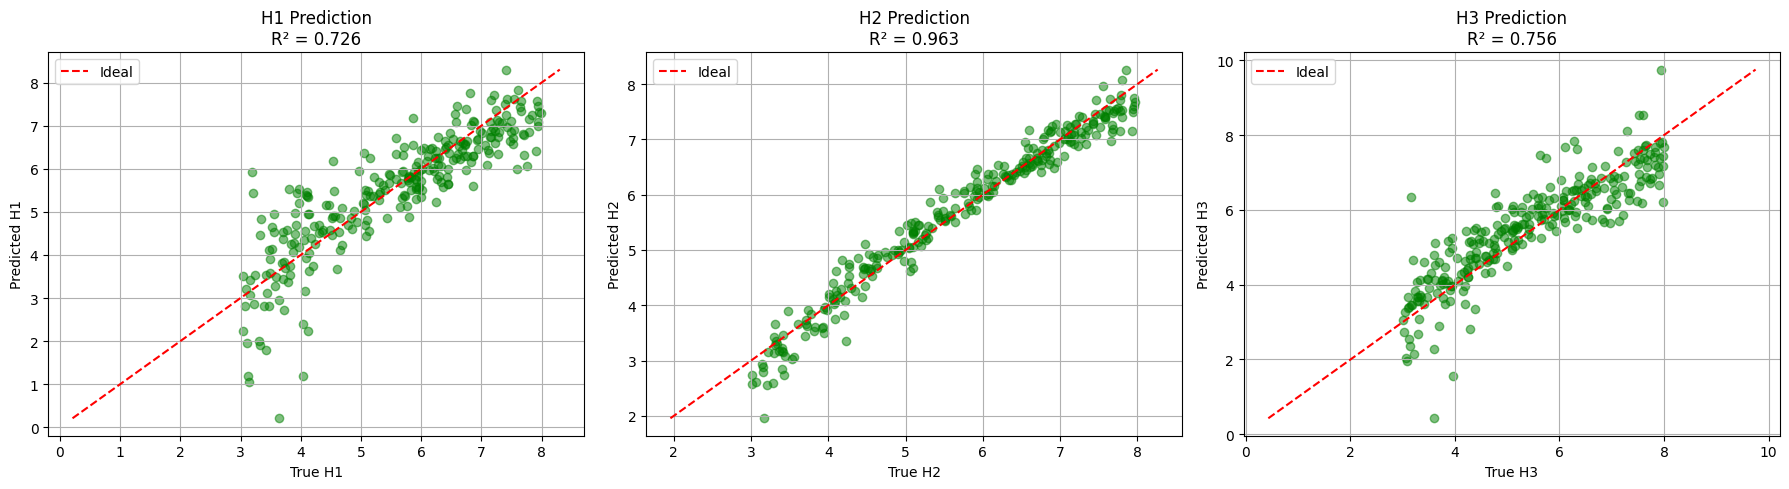

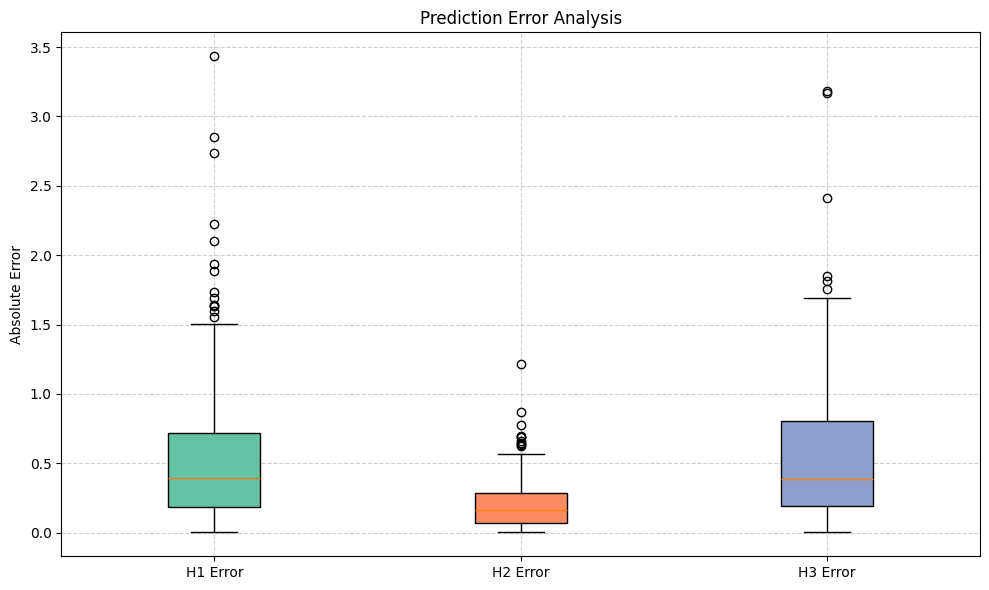

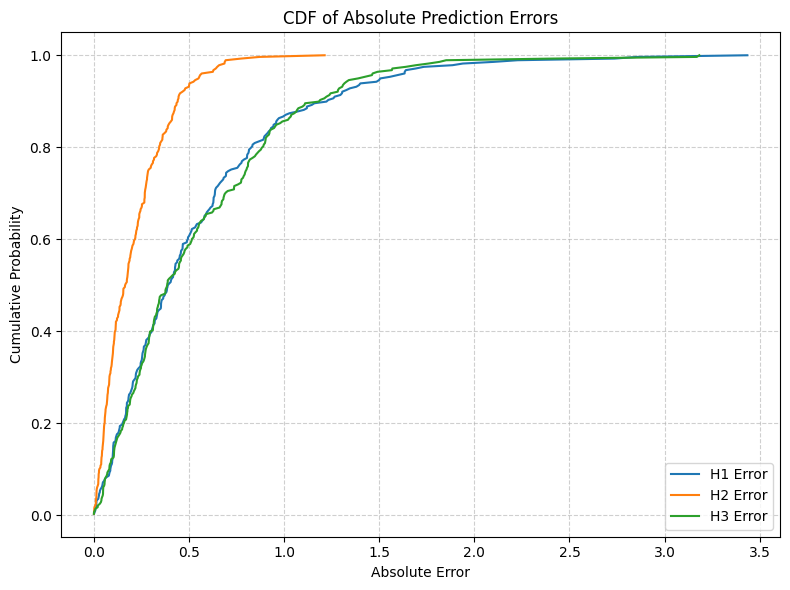

In [ ]:
from sklearn.linear_model import LinearRegression

# === Train Linear Regression ===
model = LinearRegression()
model.fit(X_train_scaled, Y_train)

# === Predictions ===
Y_pred = model.predict(X_test_scaled)
Y_true = Y_test.copy()

# === Evaluation ===
results = evaluate_predictions(Y_true, Y_pred, names=['H1', 'H2', 'H3'])

print("-------------------------------------------")

# === Comparison Table ===
comparison_df = create_comparison_df(Y_test, Y_pred, names=['H1', 'H2', 'H3'])
print(comparison_df)

print("-------------------------------------------")

# === Scatter Plots: True vs. Predicted ===
fig = plot_predictions(
    Y_test, Y_pred,
    target_names=['H1', 'H2', 'H3'],
    figsize=(18, 5),
    alpha=0.5,
    color='green'
)

# === Error Analysis (Boxplot) ===
fig, stats = plot_error_analysis(
    Y_test, Y_pred,
    target_names=['H1', 'H2', 'H3'],
    plot_type='boxplot'
)

# === CDF of Absolute Errors ===
fig = plot_error_cdfs(
    Y_test, Y_pred,
    target_names=['H1', 'H2', 'H3']
)


##XGBOOST

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# === Separate features and targets (now includes H3) ===
X = df_filtered.drop(columns=['H1', 'H2', 'H3']).values
Y = df_filtered[['H1', 'H2', 'H3']].values

# === Train/val/test split ===
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# === Min-Max Scaling ===
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled   = X_scaler.transform(X_val)
X_test_scaled  = X_scaler.transform(X_test)

Y_train_scaled = Y_scaler.fit_transform(Y_train)
Y_val_scaled   = Y_scaler.transform(Y_val)
Y_test_scaled  = Y_scaler.transform(Y_test)

# === Train a separate XGBoost model for H1, H2, H3 ===
models = []
for i in range(Y.shape[1]):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        random_state=42
    )
    model.fit(X_train_scaled, Y_train_scaled[:, i])
    models.append(model)

# === Predict and inverse transform ===
Y_pred_scaled = np.column_stack([model.predict(X_test_scaled) for model in models])
Y_pred = Y_scaler.inverse_transform(Y_pred_scaled)
Y_true = Y_scaler.inverse_transform(Y_test_scaled)


H1 → R²: 0.84580, RMSE: 0.55645, MAE: 0.39973, MAPE: 7.65%
H2 → R²: 0.94893, RMSE: 0.31987, MAE: 0.22360, MAPE: 4.07%
H3 → R²: 0.83401, RMSE: 0.59078, MAE: 0.44327, MAPE: 8.83%
-------------------------------------------
     H1_actual   H1_pred  H2_actual   H2_pred  H3_actual   H3_pred
0     4.427430  4.774369   6.145517  5.954064   7.311542  7.080577
1     7.790662  7.873833   7.146626  7.211926   4.405225  4.873671
2     6.755942  7.192776   7.130994  7.199776   5.116680  5.070413
3     3.700120  3.712909   7.089773  6.819559   5.593826  6.145879
4     7.224329  7.335505   6.118818  6.130056   5.123915  4.850618
..         ...       ...        ...       ...        ...       ...
134   6.149565  6.095497   6.983994  7.290346   5.084892  5.041813
135   5.481562  5.405680   6.613949  6.507248   7.898413  7.432225
136   5.795810  6.189034   5.755947  5.677579   5.696501  6.153444
137   7.983124  7.649733   6.432677  6.316257   7.567639  6.976218
138   7.836465  7.648036   6.382815  6.531

/tmp/ipython-input-3884306860.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=[f'{name} Error' for name in target_names], patch_artist=True)


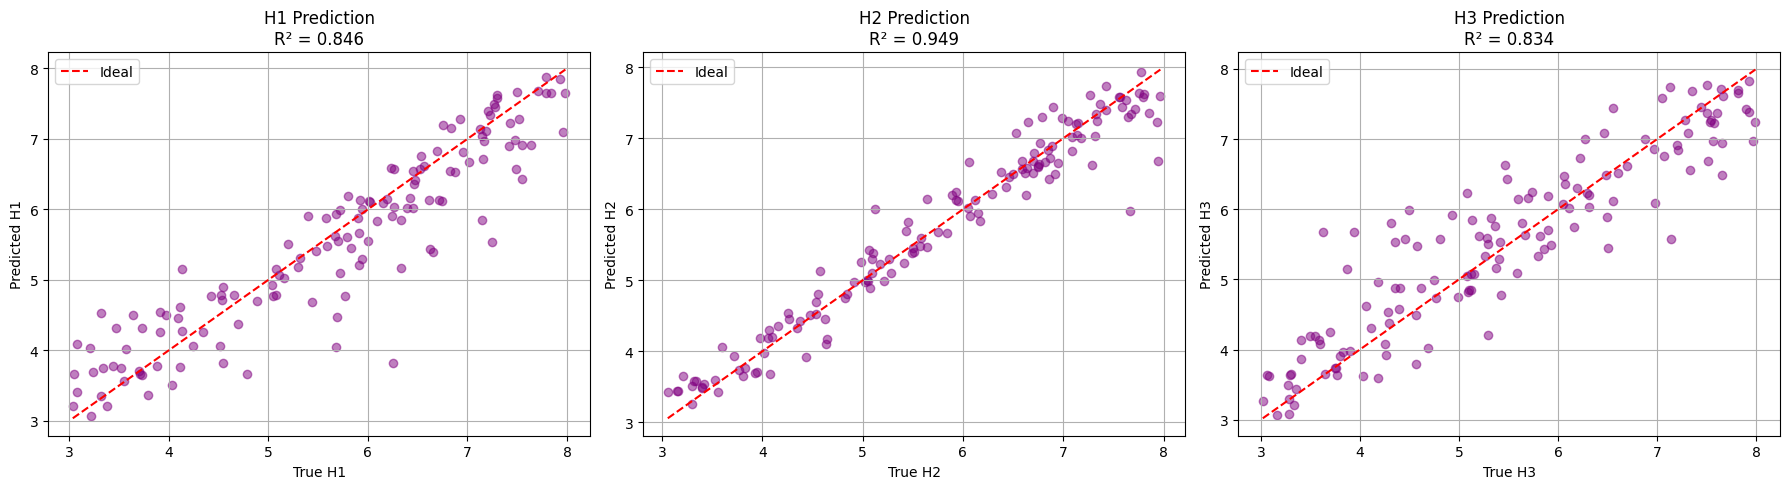

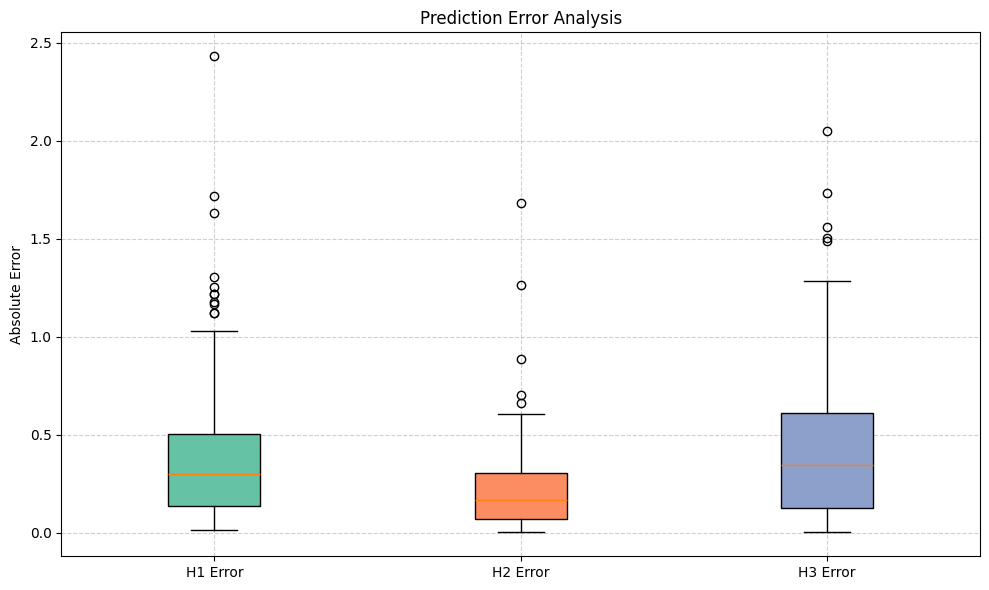

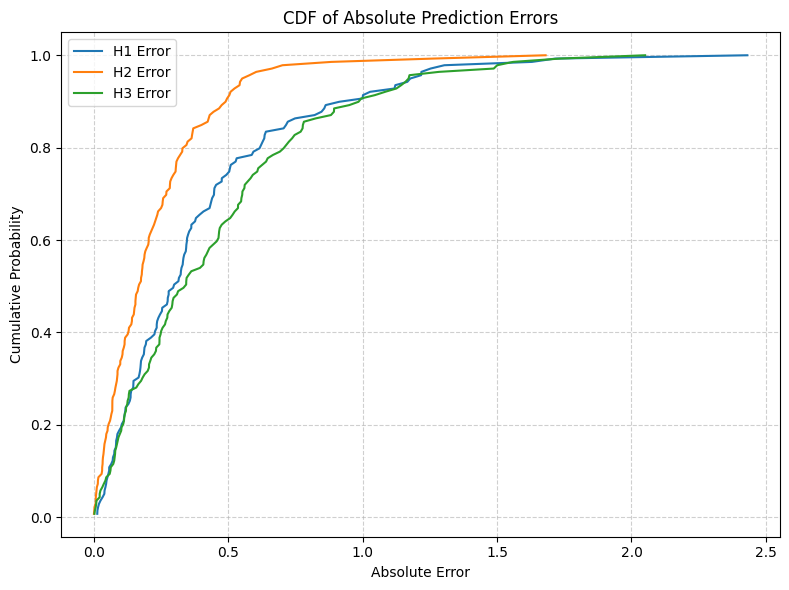

In [ ]:
results = evaluate_predictions(Y_true, Y_pred)

print("-------------------------------------------")
comparison_df = create_comparison_df(Y_test, Y_pred)
print(comparison_df)

print("-------------------------------------------")

fig = plot_predictions(
    Y_test, Y_pred,
    target_names=['H1', 'H2', 'H3'],
    figsize=(18, 5),
    alpha=0.5,
    color='purple'
)

# === Error Analysis (Boxplot) ===
fig, stats = plot_error_analysis(
    Y_test, Y_pred,
    target_names=['H1', 'H2', 'H3'],
    plot_type='boxplot'
)

# === CDF of Absolute Errors ===
fig = plot_error_cdfs(
    Y_test, Y_pred,
    target_names=['H1', 'H2', 'H3']
)


#SVR

H1 → R²: 0.89764, RMSE: 0.45238, MAE: 0.33046, MAPE: 6.73%
H2 → R²: 0.96029, RMSE: 0.28286, MAE: 0.22208, MAPE: 4.44%
H3 → R²: 0.88514, RMSE: 0.49727, MAE: 0.38984, MAPE: 7.96%
-------------------------------------------
     H1_actual   H1_pred  H2_actual   H2_pred  H3_actual   H3_pred
0     3.869904  4.107326   4.984047  4.858613   5.116563  5.888953
1     3.823586  2.861788   6.780290  6.881426   5.133340  6.084476
2     3.215969  2.781849   7.284226  7.155603   4.031593  4.225004
3     3.194046  3.344057   3.170431  3.821074   3.597011  4.703322
4     6.743159  6.921062   3.948263  4.304225   5.740581  6.358694
..         ...       ...        ...       ...        ...       ...
273   7.605381  6.995706   3.441800  4.175203   5.624078  5.543581
274   5.147789  4.947971   5.930243  5.763982   6.912173  6.819560
275   3.794412  3.076292   4.013303  4.179150   6.461412  7.573419
276   6.395177  6.825911   5.286602  5.144143   4.258512  4.261591
277   5.210386  5.295741   5.340061  5.653

/tmp/ipython-input-3884306860.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=[f'{name} Error' for name in target_names], patch_artist=True)


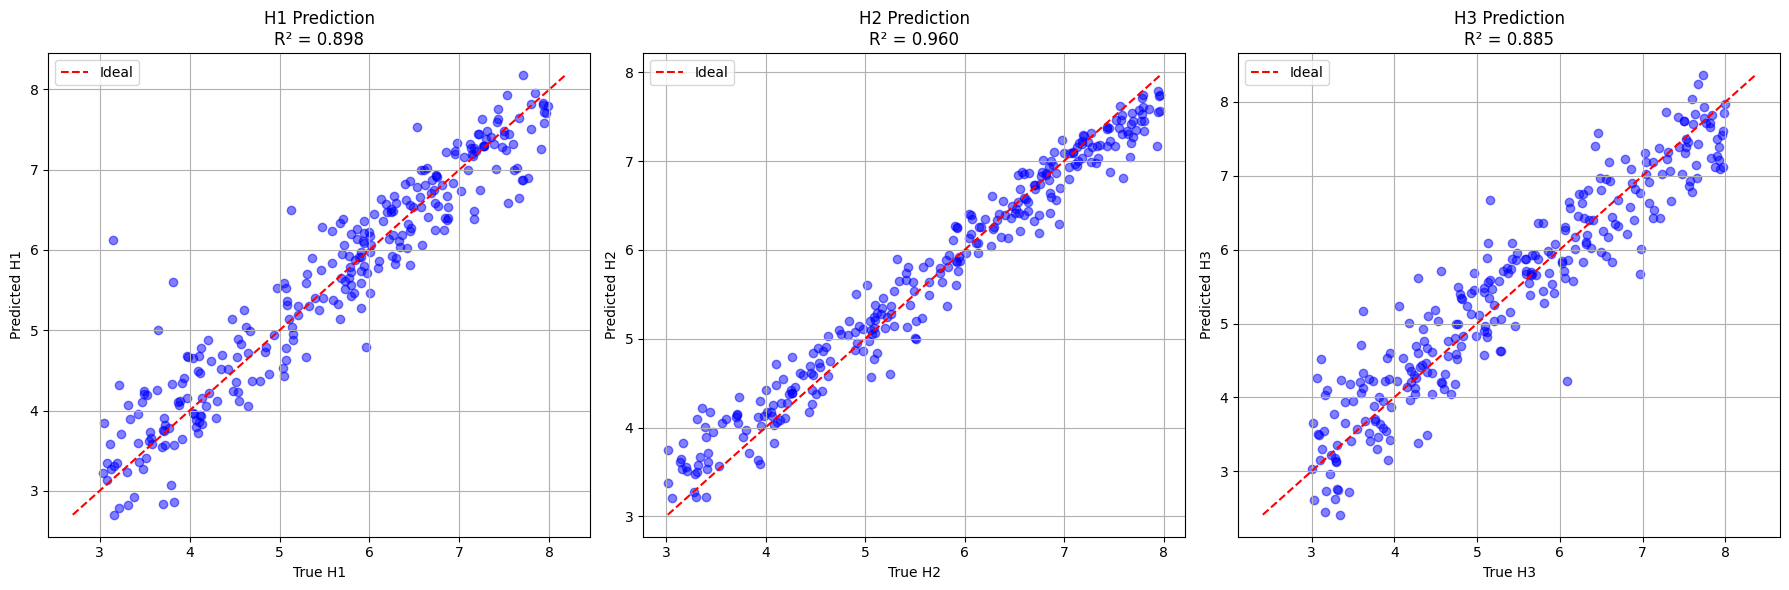

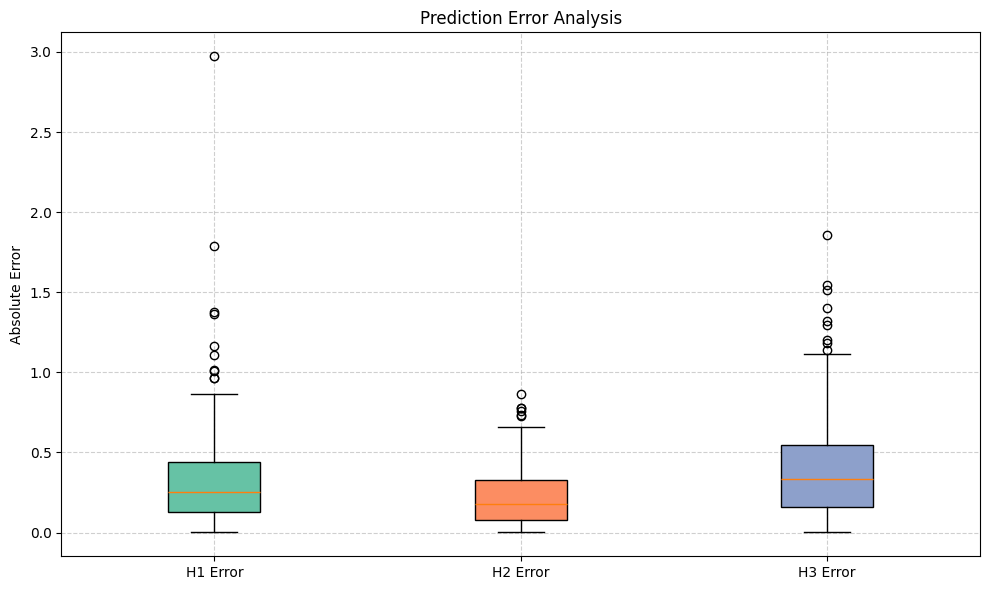

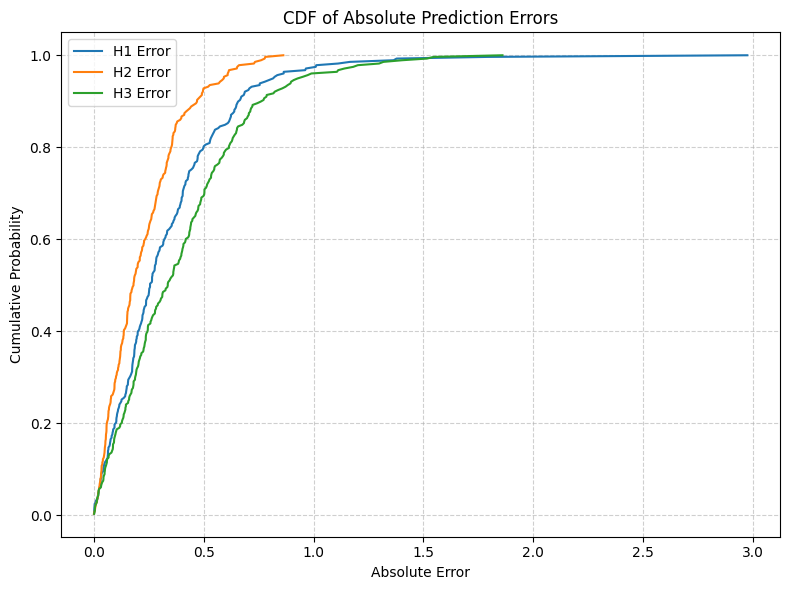

In [ ]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# === Train/test split ===
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# === Feature scaling ===
x_scaler = MinMaxScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled  = x_scaler.transform(X_test)

# === Target scaling ===
y_scaler = MinMaxScaler()
Y_train_scaled = y_scaler.fit_transform(Y_train)
Y_test_scaled  = y_scaler.transform(Y_test)

# === Multi-Output SVR ===
base_svr = SVR(kernel='rbf', C=100, epsilon=0.1)
model_svr = MultiOutputRegressor(base_svr)

model_svr.fit(X_train_scaled, Y_train_scaled)

# === Predictions and inverse transform ===
y_pred_scaled = model_svr.predict(X_test_scaled)
Y_pred = y_scaler.inverse_transform(y_pred_scaled)
Y_true = Y_test  # Already in unscaled form

# === Evaluation ===
results = evaluate_predictions(Y_true, Y_pred, names=['H1', 'H2', 'H3'])

print("-------------------------------------------")
comparison_df = create_comparison_df(Y_true, Y_pred, names=['H1', 'H2', 'H3'])
print(comparison_df)

print("-------------------------------------------")

# === Visualizations ===
fig = plot_predictions(Y_true, Y_pred,
                       target_names=['H1', 'H2', 'H3'],
                       figsize=(18, 6),
                       alpha=0.5,
                       color='blue')

fig, stats = plot_error_analysis(Y_true, Y_pred,
                                 target_names=['H1', 'H2', 'H3'])

fig = plot_error_cdfs(Y_true, Y_pred,
                      target_names=['H1', 'H2', 'H3'])


#MLP

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# # Load data
# df = pd.read_csv("simulink_feature_dataset_1000_swear.csv")
print (df.shape)


(925, 51)


In [ ]:
# === Compute absolute correlation matrix ===
corr_matrix = df.corr().abs()

# === Select only correlations of features with H1, H2, and H3 ===
target_cols = ['H1', 'H2', 'H3']
feature_corr = corr_matrix[target_cols].drop(index=target_cols)
print("🔍 Correlation of features with targets:\n")
print(feature_corr)

# === Set a minimum correlation threshold ===
threshold = 0.2

# === Keep features where correlation with at least one target exceeds the threshold ===
selected_features = feature_corr[
    (feature_corr['H1'] > threshold) |
    (feature_corr['H2'] > threshold) |
    (feature_corr['H3'] > threshold)
].index.tolist()

print(f"\n✅ Selected features (correlation > {threshold}):", selected_features)

# === Create filtered dataset with selected features + all 3 targets ===
df_filtered = df[selected_features + target_cols]


🔍 Correlation of features with targets:

                        H1        H2        H3
df1_mean          0.025121  0.029143  0.060941
df1_std           0.523937  0.197972  0.054726
df1_max           0.572789  0.201556  0.175233
df1_min           0.702811  0.122445  0.223440
df1_ptp           0.688930  0.182343  0.214820
df1_rms           0.523933  0.197973  0.054725
df1_nadir_time    0.176856  0.076974  0.069078
df1_rms_ratio     0.362848  0.365045  0.086537
df2_mean          0.005585  0.090039  0.022799
df2_std           0.112810  0.515774  0.077575
df2_max           0.240180  0.417009  0.238953
df2_min           0.399247  0.663601  0.262452
df2_ptp           0.344748  0.585651  0.284172
df2_rms           0.112807  0.515773  0.077577
df2_nadir_time    0.014780  0.028576  0.058590
df2_rms_ratio     0.064734  0.559841  0.139038
df3_mean          0.047833  0.045402  0.002785
df3_std           0.360850  0.256373  0.387960
df3_max           0.304429  0.184361  0.566587
df3_min           0

In [ ]:
# === Split into features and targets ===
X = df_filtered.iloc[:, :-3].values  # all columns except last 3
y = df_filtered.iloc[:, -3:].values  # last 3 columns: [H1, H2, H3]

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
X.shape

(925, 34)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Feature scaler
x_scaler =MinMaxScaler()
y_scaler = MinMaxScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# Target scaler (important!)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class InertiaRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = InertiaRegressionDataset(X_train_scaled, y_train_scaled)
test_dataset = InertiaRegressionDataset(X_test_scaled, y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3)  # Changed from 2 to 3 outputs
        )

    def forward(self, x):
        return self.net(x)

# Adjust input_dim if needed to match your actual number of features
model = RegressionModel(input_dim=X_train_scaled.shape[1])


In [ ]:
import torch.nn as nn
import torch

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 1500
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1:4d} | Train Loss: {avg_loss:.6f}")


Epoch    1 | Train Loss: 0.195793
Epoch    2 | Train Loss: 0.083822
Epoch    3 | Train Loss: 0.066450
Epoch    4 | Train Loss: 0.053747
Epoch    5 | Train Loss: 0.042020
Epoch    6 | Train Loss: 0.034966
Epoch    7 | Train Loss: 0.029624
Epoch    8 | Train Loss: 0.025423
Epoch    9 | Train Loss: 0.022500
Epoch   10 | Train Loss: 0.020530
Epoch   11 | Train Loss: 0.018477
Epoch   12 | Train Loss: 0.017239
Epoch   13 | Train Loss: 0.015752
Epoch   14 | Train Loss: 0.015113
Epoch   15 | Train Loss: 0.014789
Epoch   16 | Train Loss: 0.014777
Epoch   17 | Train Loss: 0.014052
Epoch   18 | Train Loss: 0.012825
Epoch   19 | Train Loss: 0.012820
Epoch   20 | Train Loss: 0.011189
Epoch   21 | Train Loss: 0.010289
Epoch   22 | Train Loss: 0.009723
Epoch   23 | Train Loss: 0.009655
Epoch   24 | Train Loss: 0.009635
Epoch   25 | Train Loss: 0.009376
Epoch   26 | Train Loss: 0.010090
Epoch   27 | Train Loss: 0.009137
Epoch   28 | Train Loss: 0.008447
Epoch   29 | Train Loss: 0.007833
Epoch   30 | T

In [ ]:
model.eval()
y_pred_all, y_true_all = [], []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        output = model(batch_x).cpu().numpy()
        y_pred_all.append(output)
        y_true_all.append(batch_y.numpy())

y_pred_all = np.concatenate(y_pred_all, axis=0)
y_true_all = np.concatenate(y_true_all, axis=0)


# After collecting predictions and targets
# Use Y_true and Y_pred to match the plotting function arguments
Y_pred = y_scaler.inverse_transform(y_pred_all)
Y_true = y_scaler.inverse_transform(y_true_all)

In [ ]:
results = evaluate_predictions(Y_true, Y_pred)

print("-------------------------------------------")
# Use the Y_true and Y_pred calculated in the previous cell for the MLP results
comparison_df = create_comparison_df(Y_true, Y_pred)
print(comparison_df)

print("-------------------------------------------")







H1 → R²: 0.97414, RMSE: 0.23103, MAE: 0.16703, MAPE: 3.09%
H2 → R²: 0.98923, RMSE: 0.14710, MAE: 0.11532, MAPE: 2.19%
H3 → R²: 0.94687, RMSE: 0.34504, MAE: 0.25086, MAPE: 4.80%
-------------------------------------------
     H1_actual   H1_pred  H2_actual   H2_pred  H3_actual   H3_pred
0     3.869905  3.989700   4.984047  5.164239   5.116563  5.305794
1     3.823586  3.691893   6.780290  6.740114   5.133340  4.701917
2     3.215969  3.065741   7.284226  7.204039   4.031593  4.039660
3     3.194046  3.050446   3.170431  3.187159   3.597011  2.683454
4     6.743159  6.848422   3.948263  3.969325   5.740581  6.064696
..         ...       ...        ...       ...        ...       ...
180   4.887124  5.002189   7.584763  7.599864   5.133584  5.084774
181   5.704408  5.986656   3.560304  3.634885   5.371351  4.760991
182   6.090018  6.167566   4.826783  4.810505   4.617981  4.484640
183   5.694665  5.270904   5.585121  5.651185   4.930963  5.047664
184   6.400650  6.642179   5.757783  5.833

-------------------------------------------


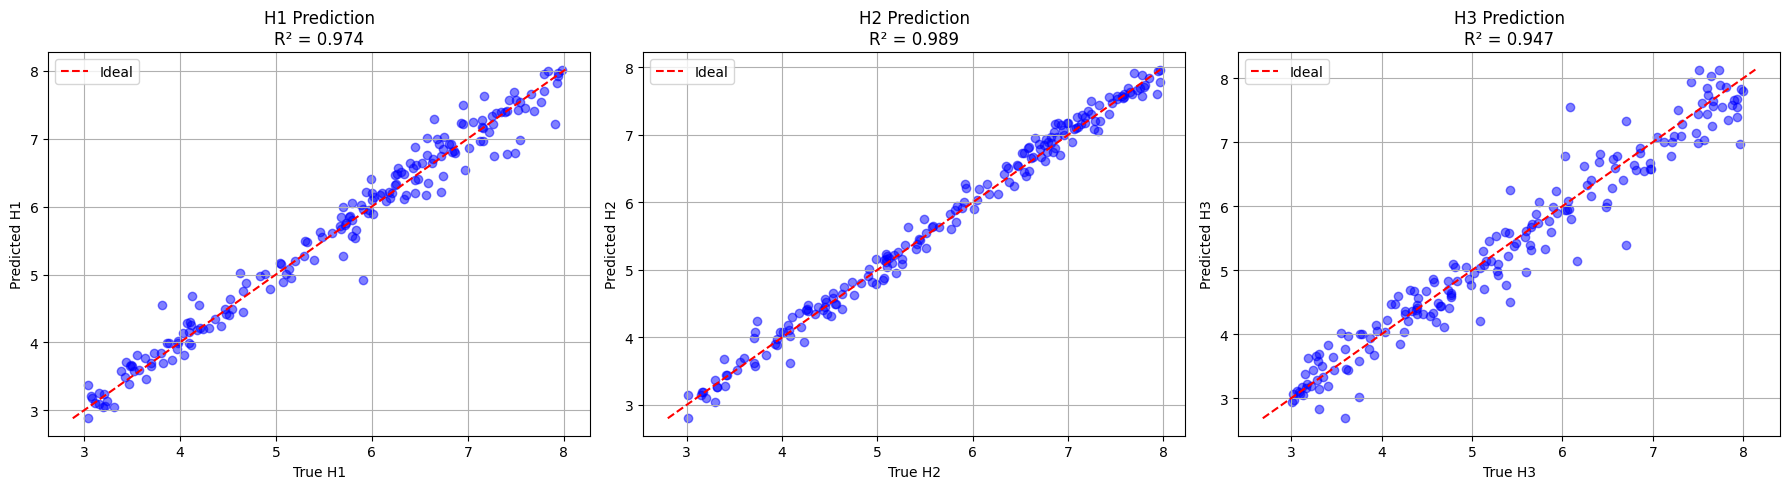

In [ ]:
print("-------------------------------------------")

fig = plot_predictions(
    Y_true, Y_pred, # Use Y_true and Y_pred calculated from MLP's test set
    target_names=['H1', 'H2', 'H3'],
    figsize=(18, 5),
    alpha=0.5,
    color='blue'
)

📊 Error Statistics:

H1:
  Mean Absolute Error: 0.1670
  Median Absolute Error: 0.1253
  Max Error: 0.9902
  Standard Deviation: 0.1596

H2:
  Mean Absolute Error: 0.1153
  Median Absolute Error: 0.0960
  Max Error: 0.5033
  Standard Deviation: 0.0913

H3:
  Mean Absolute Error: 0.2509
  Median Absolute Error: 0.1967
  Max Error: 1.4674
  Standard Deviation: 0.2369


/tmp/ipython-input-3884306860.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=[f'{name} Error' for name in target_names], patch_artist=True)


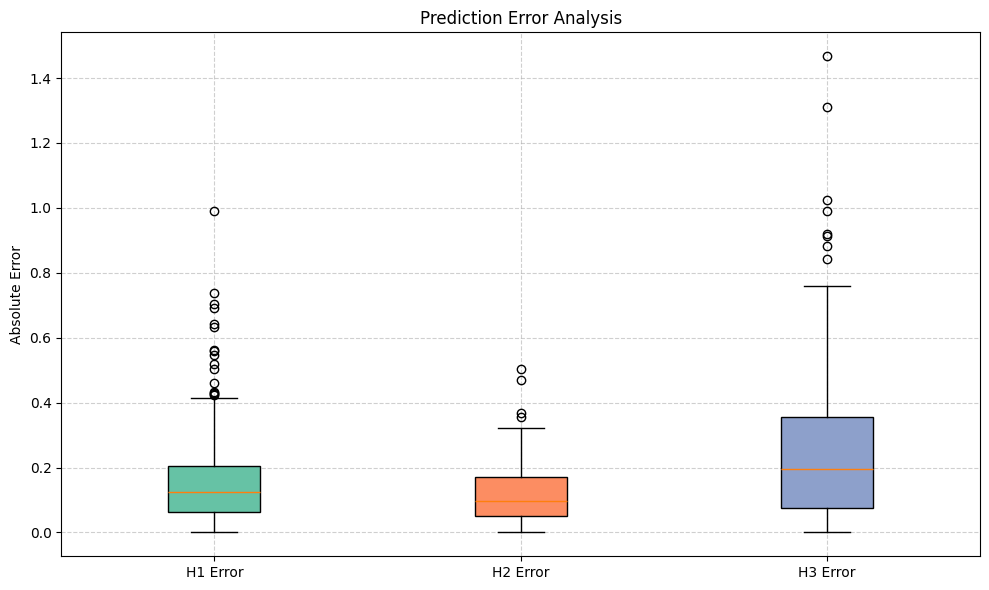

In [ ]:
# === Error Analysis (Boxplot) ===
fig, stats = plot_error_analysis(
    Y_true, Y_pred, # Use Y_true and Y_pred calculated from MLP's test set
    target_names=['H1', 'H2', 'H3'],
    plot_type='boxplot'
)

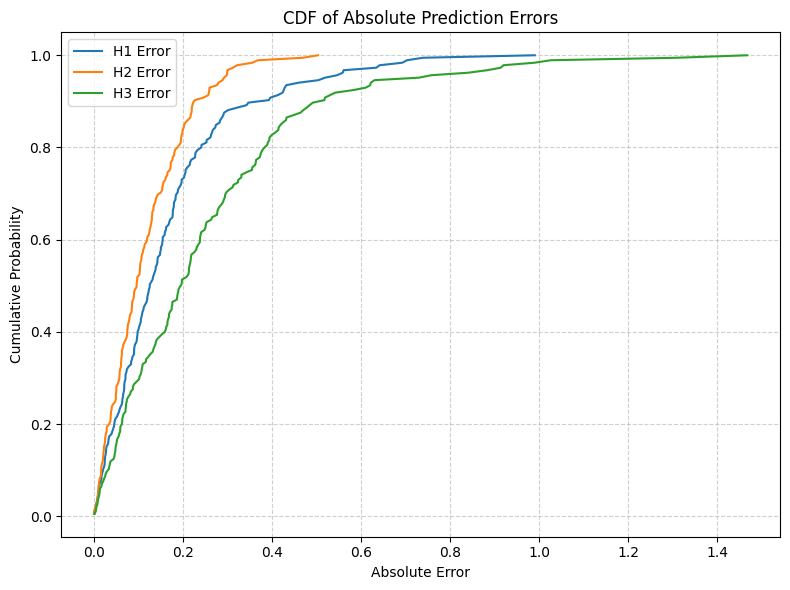

In [ ]:
# === CDF of Absolute Errors ===
fig = plot_error_cdfs(
    Y_true, Y_pred, # Use Y_true and Y_pred calculated from MLP's test set
    target_names=['H1', 'H2', 'H3']
)